## Import packages

In [1]:
# packages
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import yaml, os, sys, glob
from scipy.optimize import minimize
pd.set_option("display.max_columns", None)

from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.ticker as ticker
from astropy.coordinates import Galactic
from magicctapipe.utils  import calculate_off_coordinates
from pyirf.statistics import li_ma_significance
from pyirf.benchmarks import angular_resolution
from astropy.table import Table, QTable
from pyirf.cuts import calculate_percentile_cut#, evaluate_binned_cut
from scipy import stats, optimize
    
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
import find_files as find
aux.params() # graphic parameters


# --- other parameters --- #
# name of the source we are studying
source_name = 'Crab'
# number of off regions
n_regions_off = 5
# ------------------------ #

path_mc     = f'/fefs/aswg/workspace/juan.jimenez/data/dl2/mc/dl2_MC_mean_{source_name}.h5'
path_mc_tot = f'/fefs/aswg/workspace/juan.jimenez/data/dl2/mc/dl2_MC_merged_{source_name}.h5'
path_merged = f'/fefs/aswg/workspace/juan.jimenez/data/dl2/coincident/dl2_merged_{source_name}.h5'
path_mean   = f'/fefs/aswg/workspace/juan.jimenez/data/dl2/coincident/dl2_mean_{source_name}.h5'
path_lst    = f'/fefs/aswg/workspace/juan.jimenez/data/dl2/coincident/dl2_lst_{source_name}.h5'
path_magic  = f'/fefs/aswg/workspace/juan.jimenez/data/dl2/coincident/dl2_melibea_{source_name}.h5'

root_data   = f'/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/'
############################
gammas = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

theta2_cut  = 0.08
theta2_cuts = [0.08, 0.2, 0.08]

theta2_bins       = np.linspace(0, 0.3, 120)
theta2_bins_short = np.linspace(0, 0.1, 80)

cols = ['darkblue', 'mediumvioletred', 'c']
gamma_array = np.linspace(0, 1, 150)
label_df = ['3Tel-stereo', 'LST-lstchain', 'MAGIC-mars']

energy_bins = np.logspace(-1.2, 2.1, 15)
energy_bins_angres = np.logspace(-1.3, 1.3, 8)
energy_bins_multiplot = np.logspace(-1.2, 0.5, 7)
energy_bins_sens = 10**np.array([-1.3+0.2*k for k in range(14)])

gh_efficiency1 = 0.9
gh_efficiency2 = 0.68
############################

# creating a folder to save the plots
pltpath = 'plots/'
if not os.path.exists(pltpath):
    os.makedirs(pltpath)
dpi = 200     # resolution of saved images

In [2]:
theta2_bins_c = (theta2_bins[:-1] + theta2_bins[1:]) / 2
theta2_bins_width = [theta2_bins_c - theta2_bins[:-1], theta2_bins[1:] - theta2_bins_c,]
theta2_bins_short_c = (theta2_bins_short[:-1] + theta2_bins_short[1:]) / 2
theta2_bins_short_width = [theta2_bins_short_c - theta2_bins_short[:-1], theta2_bins_short[1:] - theta2_bins_short_c,]

energy_bins_c = (energy_bins[:-1] + energy_bins[1:]) / 2
energy_bins_width = [energy_bins_c - energy_bins[:-1], energy_bins[1:] - energy_bins_c,]

energy_bins_angres_c = (energy_bins_angres[:-1] + energy_bins_angres[1:]) / 2
energy_bins_angres_width = [energy_bins_angres_c - energy_bins_angres[:-1], energy_bins_angres[1:] - energy_bins_angres_c,]

energy_bins_multiplot_c = (energy_bins_multiplot[:-1] + energy_bins_multiplot[1:]) / 2
energy_bins_multiplot_width = [energy_bins_multiplot_c - energy_bins_multiplot[:-1], energy_bins_multiplot[1:] - energy_bins_multiplot_c,]

energy_bins_sens_c = (energy_bins_sens[:-1] + energy_bins_sens[1:]) / 2
energy_bins_sens_width = [energy_bins_sens_c - energy_bins_sens[:-1], energy_bins_sens[1:] - energy_bins_sens_c,]


## Reading all dataframes

In [3]:
# reading the main files
df_mc_mean =  pd.read_hdf(path_mc,   key='events/parameters')
df_mc_tot  =  pd.read_hdf(path_mc_tot,   key='events/parameters')
df_merged  =  pd.read_hdf(path_merged,   key='events/parameters')

df_mean   =  pd.read_hdf(path_mean,   key='events/parameters')
df_lst    =  pd.read_hdf(path_lst,    key='events/parameters')
df_magic  =  pd.read_hdf(path_magic,  key='events/parameters')

print(f'The merged-dl2 ({sys.getsizeof(df_merged)*1e-9:.1f}Gb) and {len(df_merged)} events:')
display(df_merged.head(5))
print(f'The mean-dl2 ({sys.getsizeof(df_mean)*1e-9:.1f}Gb) and {len(df_mean)} events:')
display(df_mean.head(5))
print(f'The lst-dl2 ({sys.getsizeof(df_mean)*1e-9:.1f}Gb) and {len(df_lst)} events:')
display(df_lst.head(5))
print(f'The magic-dl2 ({sys.getsizeof(df_mean)*1e-9:.1f}Gb) and {len(df_magic)} events:')
display(df_magic.head(5))

The merged-dl2 (5.0Gb) and 8938695 events:


obs_id_magic  event_id_magic  obs_id_lst  \
obs_id event_id tel_id                                             
2923   2054766  1            5093174            2132      2923.0   
                2            5093174            2132      2923.0   
                3            5093174            2132      2923.0   
       2054879  1            5093174            2134      2923.0   
                2            5093174            2134      2923.0   

                        event_id_lst    intensity         x         y  \
obs_id event_id tel_id                                                  
2923   2054766  1          2054766.0  1539.117331  0.159153 -0.199730   
                2          2054766.0   682.101041  0.219247 -0.123636   
                3          2054766.0   830.125000  0.211807 -0.165825   
       2054879  1          2054879.0   222.561295 -0.455197  0.046522   
                2          2054879.0   185.757812  0.322648  0.192534   

                               r         phi    length  length_uncertainty  \
obs_id event_id tel_id                                                       
2923   2054766  1       0.255385  -51.450648  0.095864            0.003028   
                2       0.251705  -29.419061  0.100258            0.002468   
                3       0.268999  -38.057629  0.094508            0.003121   
       2054879  1       0.457568  174.164535  0.041649            0.003202   
                2       0.375727   30.825800  0.036762            0.001455   

                           width  width_uncertainty        psi  skewness  \
obs_id event_id tel_id                                                     
2923   2054766  1       0.041476           0.001832  39.938156 -0.450708   
                2       0.039357           0.001128  65.294646 -0.720628   
                3       0.030039           0.000740  80.270400  0.379087   
       2054879  1       0.032359           0.001995 -78.978052 -0.425175   
                2       0.028710           0.001415  24.925432  0.411584   

                        kurtosis     slope  intercept  intensity_width_1  \
obs_id event_id tel_id                                                     
2923   2054766  1       2.467139 -7.488149  19.800128                0.0   
                2       2.653032  7.173953  15.740397                0.0   
                3       4.620778 -5.738219  18.871566                0.0   
       2054879  1       2.256291 -2.457408  15.740922                0.0   
                2       2.163804  3.734823  12.596438                0.0   

                        intensity_width_2  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                      
2923   2054766  1                0.000000             0.0        0.000000   
                2                0.000000             0.0        0.000000   
                3                0.000000             0.0        0.000000   
       2054879  1                0.000000             0.0        0.000000   
                2                0.022543             0.0        0.000962   

                        n_pixels  n_islands  pointing_alt  pointing_az  \
obs_id event_id tel_id                                                   
2923   2054766  1             42          1      0.784340     1.508031   
                2             61          1      0.784258     1.508029   
                3             46          2      0.784235     1.508001   
       2054879  1             10          1      0.784341     1.508032   
                2             19          1      0.784258     1.508029   

                           timestamp  time_diff  multiplicity  combo_type  \
obs_id event_id tel_id                                                      
2923   2054766  1       1.605743e+09   0.000020             3           3   
                2       1.605743e+09   0.002003             3           3   
                3       1.605743e+09   0.002003        

The mean-dl2 (0.8Gb) and 2979565 events:


combo_type  multiplicity     timestamp  pointing_alt  \
obs_id event_id                                                         
2923   2054766            3             3  1.605743e+09      0.784278   
       2054879            3             3  1.605743e+09      0.784278   
       2054932            3             3  1.605743e+09      0.784279   
       2055078            3             3  1.605743e+09      0.784279   
       2055274            3             3  1.605743e+09      0.784281   

                 pointing_az  reco_energy   reco_alt    reco_az  gammaness  \
obs_id event_id                                                              
2923   2054766      1.508020     1.043925  45.828519  86.617489   0.486476   
       2054879      1.508021     0.343145  44.369272  86.108064   0.010833   
       2054932      1.508021     0.331730  43.793342  85.654745   0.567683   
       2055078      1.508021     7.284849  44.127087  89.579022   0.022222   
       2055274      1.508022     1.527714  44.070045  87.364394   0.419333   

                 pointing_ra  pointing_dec    reco_ra   reco_dec  \
obs_id event_id                                                    
2923   2054766     83.966939     22.246320  83.000934  22.391517   
       2054879     83.966939     22.246321  84.619623  22.261177   
       2054932     83.966939     22.246322  85.322760  22.382477   
       2055078     83.966940     22.246323  83.950691  19.842418   
       2055274     83.966940     22.246324  84.601973  21.312493   

                     total_id  theta2_on  theta2_off1  theta2_off2  \
obs_id event_id                                                      
2923   2054766   2923.2054766   0.485831     1.457949     0.774216   
       2054879   2923.2054879   0.896131     0.132843     0.558414   
       2054932   2923.2054932   2.583116     0.896444     1.747791   
       2055078   2923.2055078   4.800598     7.061302     7.779579   
       2055274   2923.2055274   1.301577     1.437852     2.142712   

                 theta2_off3  theta2_off4  theta2_off5  pointing_zd    reco_zd  
obs_id event_id                                                                 
2923   2054766      0.288728     1.170674     1.656184   -89.215722 -44.171481  
       2054879      0.939765     0.469956     0.088614   -89.215722 -45.630728  
       2054932      2.590600     1.730641     0.887869   -89.215721 -46.206658  
       2055078      6.647519     4.079161     5.211073   -89.215721 -45.872913  
       2055274      2.073632     0.594867     0.663942   -89.215719 -45.929955

The lst-dl2 (0.8Gb) and 2979565 events:


intensity         x         y         r       phi  \
obs_id event_id                                                        
2923   2054766   1539.117331  0.159153 -0.199730  0.255385 -0.897983   
       2054879    222.561295 -0.455197  0.046522  0.457568  3.039745   
       2054932    493.258595 -0.599963 -0.179310  0.626185 -2.851175   
       2055078   5716.545122 -0.133117  0.249002  0.282351  2.061740   
       2055274   1982.416317  0.194891  0.360309  0.409640  1.074966   

                   length     width       psi  time_gradient  intercept  \
obs_id event_id                                                           
2923   2054766   0.196164  0.084872  0.697052      -7.488149  19.800128   
       2054879   0.085226  0.066215 -1.378427      -2.457408  15.740922   
       2054932   0.161016  0.115821 -1.029677      10.961353  15.071617   
       2055078   0.512571  0.160540 -1.413655      12.083996  26.947308   
       2055274   0.319193  0.215267  0.199006      14.399923  16.464350   

                 pointing_alt  pointing_az   dragon_time   delta_t  \
obs_id event_id                                                      
2923   2054766       0.784340     1.508031  1.605743e+09  0.000020   
       2054879       0.784341     1.508032  1.605743e+09  0.000029   
       2054932       0.784341     1.508032  1.605743e+09  0.000047   
       2055078       0.784342     1.508032  1.605743e+09  0.000082   
       2055274       0.784343     1.508032  1.605743e+09  0.000009   

                 reco_energy  reco_alt   reco_az  gammaness  reco_src_x  \
obs_id event_id                                                           
2923   2054766      1.296785  0.802239  1.512487   0.849113    0.501298   
       2054879      0.147946  0.769320  1.501430   0.050762   -0.420268   
       2054932      0.558524  0.766855  1.489840   0.201653   -0.487265   
       2055078      5.329910  0.775219  1.554315   0.006266   -0.240307   
       2055274      3.378833  0.769079  1.519712   0.006773   -0.426417   

                 reco_src_y  reco_disp_norm      total_id    reco_ra  \
obs_id event_id                                                        
2923   2054766     0.086735        0.446235  2923.2054766  82.850277   
       2054879    -0.132808        0.182700  2923.2054879  84.936292   
       2054932    -0.366841        0.218789  2923.2054932  85.247786   
       2055078     0.925506        0.684944  2923.2055078  83.804180   
       2055274     0.235006        0.633818  2923.2055274  84.682111   

                  reco_dec  pointing_ra  pointing_dec  theta2_on  theta2_off1  \
obs_id event_id                                                                 
2923   2054766   22.407492    83.962253     22.246814   0.680898     1.790172   
       2054879   22.222370    83.962253     22.246817   1.500806     0.417679   
       2054932   22.628811    83.962253     22.246818   2.609381     0.794979   
       2055078   20.295665    83.962252     22.246822   2.975666     4.983686   
       2055274   21.507596    83.962251     22.246827   1.204546     1.075200   

                 theta2_off2  theta2_off3  theta2_off4  theta2_off5  \
obs_id event_id                                                       
2923   2054766      1.008564     0.454574     1.463760     2.017778   
       2054879      1.064476     1.605577     0.853051     0.311970   
       2054932      1.523335     2.430204     1.880296     0.973452   
       2055078      5.455453     4.450168     2.501507     3.506693   
       2055274      1.769295     1.833138     0.508808     0.444969   

                 pointing_zd    reco_zd  
obs_id event_id                          
2923   2054766    -89.215660 -89.197761  
       2054879    -89.215659 -89.230680  
       2054932    -89.215659 -89.233145  
       2055078    -89.215658 -89.224781  
       2055274    -89.215657 -89.230921

The magic-dl2 (0.8Gb) and 2979565 events:


intensity_M1  intensity_M2  src_pos_M1_X  src_pos_M1_Y  \
obs_id  event_id                                                           
5093174 2132        682.093750    830.125000    -95.093643    -67.696632   
        2134        185.757812     60.031250    -95.094864    -67.695946   
        2136        210.335938    165.843750    -95.095299    -67.695694   
        2140       1205.257812   1114.429688    -95.096870    -67.694801   
        2141         89.109375    321.953125    -95.099022    -67.693573   

                  src_pos_M2_X  src_pos_M2_Y     imp_par_1  imp_par_1_Az  \
obs_id  event_id                                                           
5093174 2132        -95.007812    -69.127335     -1.000000           NaN   
        2134        -95.007668    -69.127419     -1.000000           NaN   
        2136        -95.007614    -69.127449  10451.465820   -137.226624   
        2140        -95.007416    -69.127563  33079.812500    -39.287201   
        2141        -95.007156    -69.127724  37034.121094    -96.295853   

                     imp_par_2  imp_par_2_Az   st_dirX   st_dirY  reco_energy  \
obs_id  event_id                                                                
5093174 2132         -1.000000           NaN       NaN       NaN    -0.001000   
        2134         -1.000000           NaN       NaN       NaN    -0.001000   
        2136       4024.333984   -102.823845  0.476395  1.154509     0.298624   
        2140      37042.355469    -28.298143 -1.908767  0.630050     8.639783   
        2141      33820.605469    -85.031845 -0.770281  0.842653     1.631842   

                  gammaness   reco_dec    reco_ra  pointing_alt  pointing_az  \
obs_id  event_id                                                               
5093174 2132       0.067190        NaN        NaN     44.933542    86.399671   
        2134       0.000000        NaN        NaN     44.933578    86.399689   
        2136       0.484714  22.311983  85.326090     44.933591    86.399695   
        2140       0.000000  20.234385  83.950481     44.933637    86.399718   
        2141       0.173393  21.239693  84.563913     44.933700    86.399749   

                        h_max   slope_1   slope_2  pointing_ra  pointing_dec  \
obs_id  event_id                                                               
5093174 2132          -1.0000  0.431198  0.169814    83.983333     22.243889   
        2134          -1.0000  1.135765 -1.296749    83.983333     22.243889   
        2136      886068.6250  0.714785 -1.347897    83.983333     22.243889   
        2140      968358.7500 -0.567660 -0.512080    83.983333     22.243889   
        2141      978703.0625  1.497397 -1.392613    83.983333     22.243889   

                     timestamp   delta_t      magic_id  theta2_on  \
obs_id  event_id                                                    
5093174 2132      1.737312e+09  0.002003  5093174.2132        NaN   
        2134      1.737705e+09  0.004651  5093174.2134        NaN   
        2136      1.737845e+09  0.002138  5093174.2136   2.546927   
        2140      1.738355e+09  0.003429  5093174.2140   3.252068   
        2141      1.739049e+09  0.008976  5093174.2141   1.346854   

                  theta2_off1  theta2_off2  theta2_off3  theta2_off4  \
obs_id  event_id                                                       
5093174 2132              NaN          NaN          NaN          NaN   
        2134              NaN          NaN          NaN          NaN   
        2136         0.867888     1.742949     2.581884     1.670621   
        2140         5.145523     5.786773     4.838509     2.607934   
        2141         1.570236     2.293316     2.180585     0.621737   

                  theta2_off5  pointing_zd  
obs_id  event_id                            
5093174 2132              NaN   -45.066458  
        2134              NaN   -45.066422  
        2136         0.831725   -45.066409  
        2140         3.556091   -45.066363  
   

## Extractting the values from the dataframes

In [4]:
# thetas of each dataframe filtered in gammaness
Ton_mean  = [df_mean[ f'theta2_on'][df_mean[ 'gammaness']>=g].to_numpy() for g in gammas]
Ton_lst   = [df_lst[  f'theta2_on'][df_lst[  'gammaness']>=g].to_numpy() for g in gammas]
Ton_magic = [df_magic[f'theta2_on'][df_magic['gammaness']>=g].to_numpy() for g in gammas]

Toff_mean, Toff_lst, Toff_magic = [], [], []
for n in range(n_regions_off):
    Toff_mean.append( [df_mean[ f'theta2_off{n+1}'][df_mean[ 'gammaness']>=g].to_numpy() for g in gammas])
    Toff_lst.append(  [df_lst[  f'theta2_off{n+1}'][df_lst[  'gammaness']>=g].to_numpy() for g in gammas])
    Toff_magic.append([df_magic[f'theta2_off{n+1}'][df_magic['gammaness']>=g].to_numpy() for g in gammas])

### RA-Dec plots

ON coordinate (Crab):
<SkyCoord (ICRS): (ra, dec) in deg
    (83.6333, 22.0133)>

For 3tel-stereo:


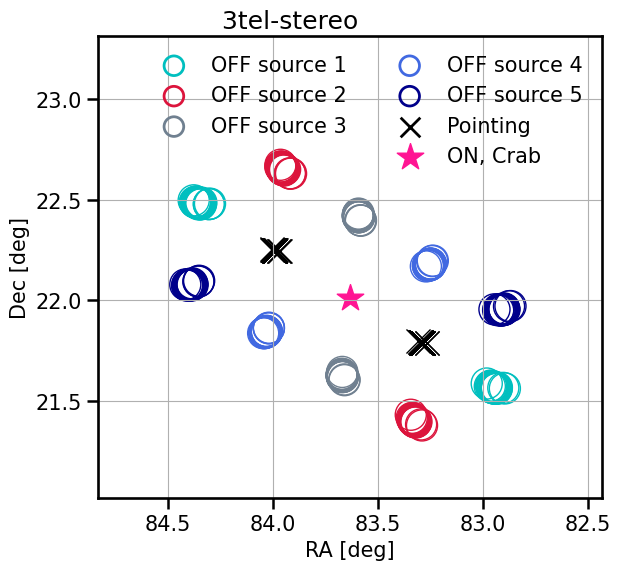


For LST1-lstchain:


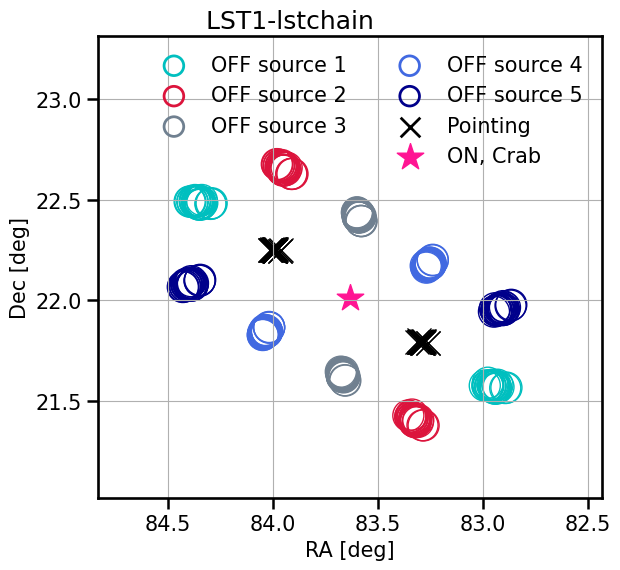


For MAGIC-mars:


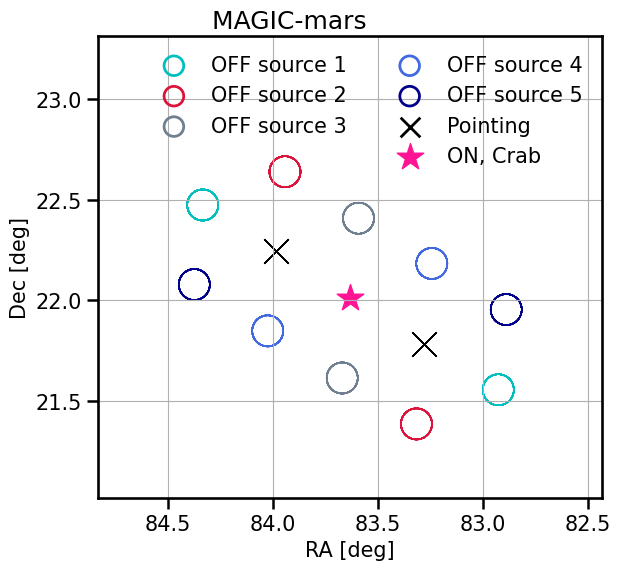

In [5]:
colors_off = ['c', 'crimson', 'slategray', 'royalblue', 'darkblue']

# extracting sky coordinates of the source we are studing
on_coord = SkyCoord.from_name(source_name, frame='icrs')
print(f'ON coordinate ({source_name}):\n{on_coord}')

for name, df in zip(['3tel-stereo', 'LST1-lstchain', 'MAGIC-mars'], [df_mean, df_lst, df_magic]):
    print(f'\nFor {name}:')
    fig, ax = plt.subplots(figsize=(6.5, 6))
    
    obs_ids = np.unique(df.index.get_level_values('obs_id'))
    for obs_id in obs_ids:

            df_events = df.query(f'obs_id == {obs_id}')

            # extracting event coordinates
            event_coords = SkyCoord(
                u.Quantity(df_events['reco_ra'], unit='deg'),
                u.Quantity(df_events['reco_dec'], unit='deg'),
                frame='icrs',)
            # extracting mean values
            pnt_ra_mean  = df_events['pointing_ra'].mean()  * u.deg
            pnt_dec_mean = df_events['pointing_dec'].mean() * u.deg

            # plot the pointing mean direction
            ax.scatter(pnt_ra_mean, pnt_dec_mean, marker='x', s=300, color='k', linewidths=1)

            # calculate the angular distances from the ON region
            theta2_on = on_coord.separation(event_coords).to_value('deg') ** 2

            # appending the data to the total dataframe
            df.loc[(obs_id, slice(None)), 'theta2_on'] = theta2_on

            # calculate the OFF coordinates
            off_coords = calculate_off_coordinates(
                pointing_ra=pnt_ra_mean,
                pointing_dec=pnt_dec_mean,
                on_coord_ra=on_coord.ra,
                on_coord_dec=on_coord.dec,
                n_regions=n_regions_off,)

            # iterate over all off regions
            off_iter = 0
            for i_off, off_coord in off_coords.items():
                # calculate the angular distance from the OFF coordinate
                theta2_off = off_coord.separation(event_coords).to_value('deg') ** 2

                # appending the data to the total dataframe
                df.loc[(obs_id, slice(None)), f'theta2_off{i_off}'] = theta2_off

                # plot the OFF coordinate
                ax.scatter(off_coord.ra.to('deg'), off_coord.dec.to('deg'), marker='o', s=500, facecolors='none', edgecolors=colors_off[off_iter])
                off_iter = off_iter + 1

    # legend markers
    for i in range(n_regions_off):
        if i == 3:
            ax.plot([], [], marker='', label=' ', ls='')
        ax.scatter([], [], marker='o', s=200, facecolors='none', edgecolors=colors_off[i], label=f'OFF source {i+1}', linewidths=2)

    ax.scatter([], [], marker='x', s=200, color='k', linewidths=2, label='Pointing')
    # plot the ON coordinate
    ax.scatter(on_coord.ra.to('deg'), on_coord.dec.to('deg'), label=f'ON, {source_name}', marker='*', s=400, color='deeppink')

    ax.set_title(f'{name}               ')
    ax.set_xlabel('RA [deg]')
    ax.set_ylabel('Dec [deg]')
    # converting the coordinated to degrees and adding 2 degrees by both sides
    xlim = on_coord.ra.to_value('deg')  + np.array([1.2, -1.2])
    ylim = on_coord.dec.to_value('deg') + np.array([-1, 1.3])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid()
    leg = ax.legend(loc=1, frameon=False, fontsize=15, ncol=2, numpoints=1) # bbox_to_anchor=(1.1, 1.05))
    leg.get_frame().set_alpha(None)
    plt.show()


### First $\theta^2$ plot

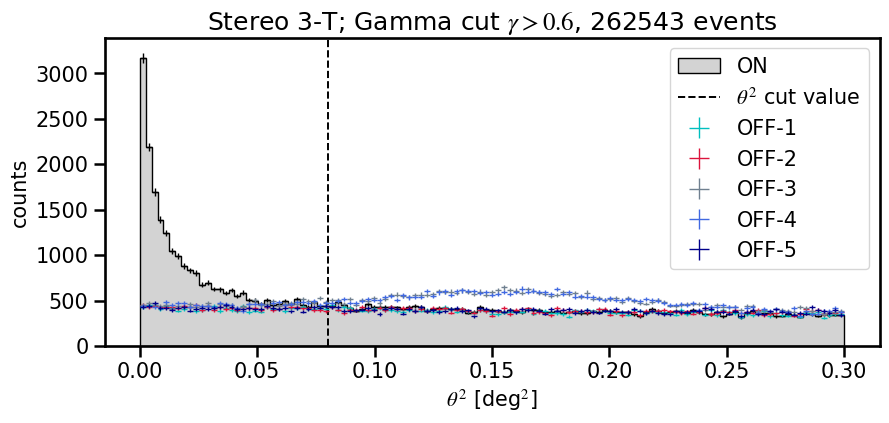

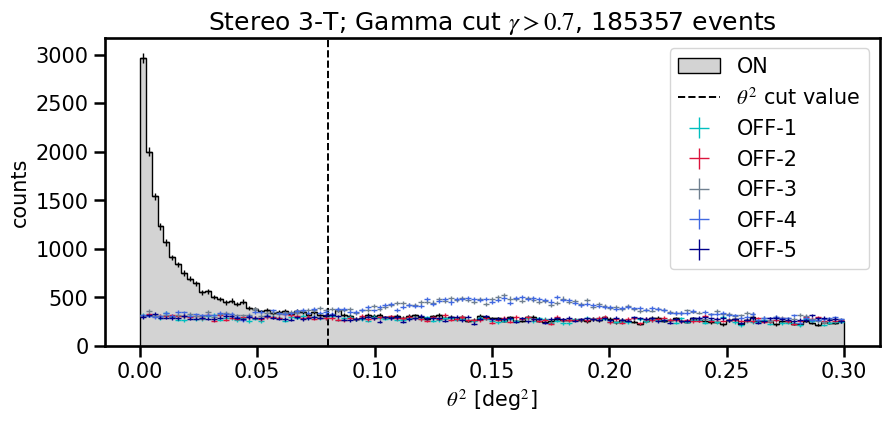

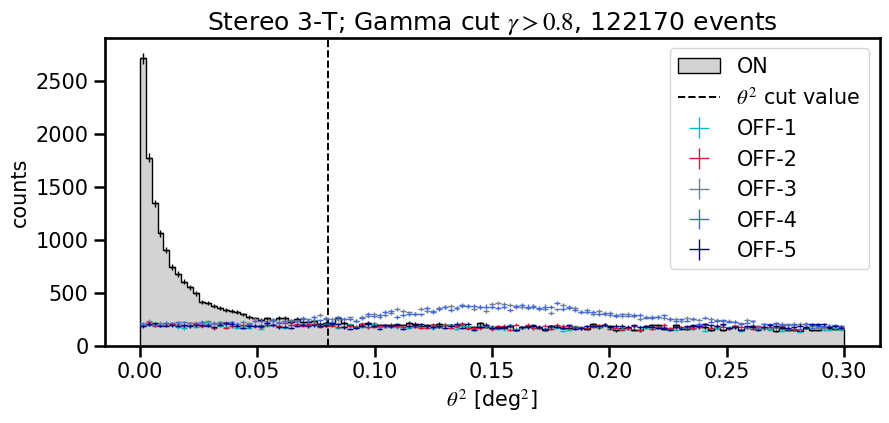

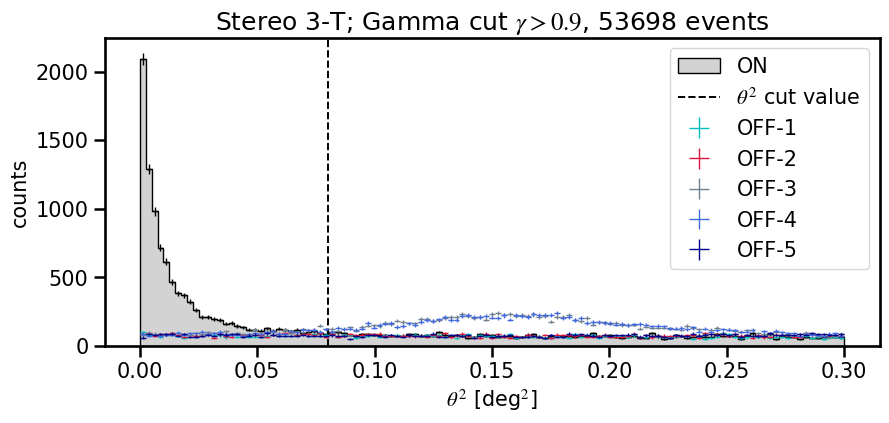

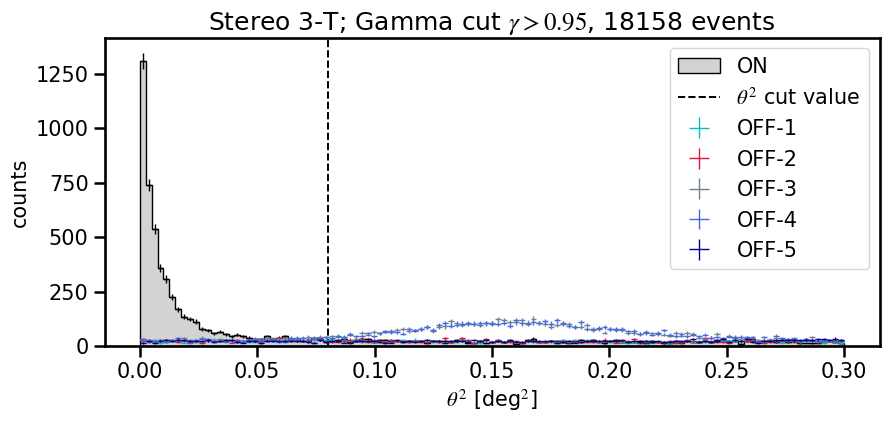

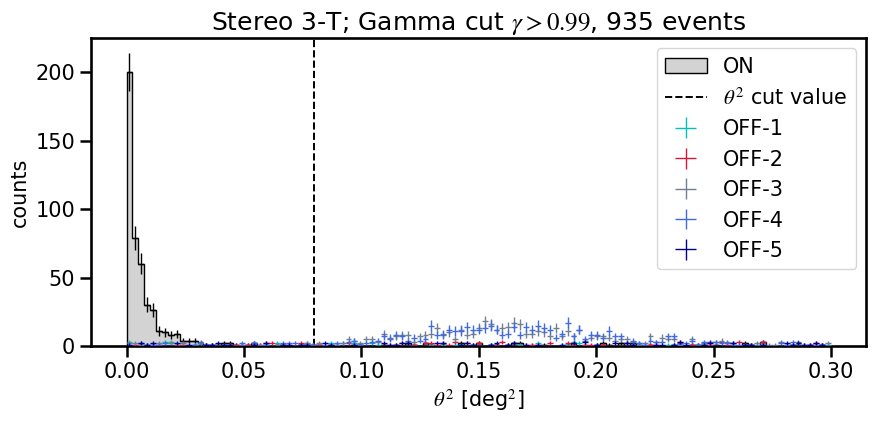

In [6]:
for gi in range(len(gammas)):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.set_title(f'Stereo 3-T; Gamma cut $\gamma>{gammas[gi]}$, {len(Ton_mean[gi])} events')

    hist_on, _, _ = ax.hist(Ton_mean[gi], bins=theta2_bins, color='lightgrey', edgecolor='k', alpha=1, histtype='stepfilled', label='ON')
    plt.errorbar(theta2_bins_c, hist_on, xerr=theta2_bins_width, yerr=np.sqrt(hist_on), fmt='.', ms=0, color='k', zorder=10, lw=1)


    for i in range(n_regions_off):
        hist_off, _ = np.histogram(Toff_mean[i][gi], bins=theta2_bins)
        plt.errorbar(theta2_bins_c, hist_off, xerr=theta2_bins_width, yerr=np.sqrt(hist_off), fmt='.', ms=0, color=colors_off[i], zorder=10, lw=1, 
                    label=f'OFF-{i+1}')

    ax.axvline(theta2_cut, color='k', lw=1.4, ls='--', label='$\\theta^2$ cut value')
    ax.set_xlabel('$\\theta^2$ [deg$^2$]')
    ax.set_ylabel('counts')
    ax.legend(loc=1)
    plt.show()

# - Filtering by significance

In [7]:
compute = False

time_diffs = np.diff(df_mean['timestamp'].to_numpy())
obs_time   = time_diffs[time_diffs < 1].sum()
print(f'The total observation time is: {obs_time/3600:.2f} h')

# Calculate the numbers ON, OFF and excess events
dfs_s = [df_mean.copy(), df_lst.copy(), df_magic.copy()]
dfs_s = [df[['gammaness', 'theta2_on', 'reco_energy', *[f'theta2_off{i+1}' for i in range(n_regions_off)]]] for df in dfs_s]
    
if compute:

    significance = [[] for _ in dfs_s]
    n_ons_fix    = [[] for _ in dfs_s]
    n_offs_fix   = [[] for _ in dfs_s]

    tmp_dfs = dfs_s.copy()

    for g in range(len(gamma_array)):

        if g % 20 == 0:
            print(f'Computing {g / len(gamma_array) * 100:.0f}%...')

        for i in range(len(dfs_s)):

            tmp_dfs[i] = tmp_dfs[i].query(f'gammaness >= {gamma_array[g]}', inplace=False)

            n_off = sum([sum(tmp_dfs[i][f'theta2_off{j+1}'] < theta2_cuts[i]) for j in range(n_regions_off)])
            n_on  = sum(tmp_dfs[i]['theta2_on'] < theta2_cuts[i])

            n_offs_fix[i].append(n_off)
            n_ons_fix[i].append(n_on)
            significance[i].append(li_ma_significance(n_on, n_off, alpha=1/n_regions_off))
        
    significance = np.array(significance)
    np.savetxt(f'{root_data}data/significances.txt', significance)

else:
    significance = np.loadtxt(f'{root_data}data/significances.txt')
        

The total observation time is: 10.51 h


In [8]:
# calculate the optimal gammas
def neg_WStat(gammaness, i):
    
    df = dfs_s[i].query(f'gammaness >= {gammaness}', inplace=False)[['gammaness', 'theta2_on', *[f'theta2_off{i+1}' for i in range(n_regions_off)]]]
    
    n_on  = sum(df['theta2_on'] < theta2_cut)
    n_off = sum([sum(df[f'theta2_off{j+1}'] < theta2_cut) for j in range(n_regions_off)])
        
    return -1 * li_ma_significance(n_on, n_off, alpha=1/n_regions_off)

opt_gamma_s = []
for i in range(len(significance)):
    opt_gamma_s.append(minimize(neg_WStat, x0=[0.7], bounds=[(0,1)], args=(i), method='Nelder-Mead').x[0])
    
print(f'The maxiumum significances are given by:')
for i in range(len(significance)):
    maxgamma, maxsig = gamma_array[list(significance[i]).index(max(significance[i]))], max(significance[i])
    nevs  = len(dfs_s[i][dfs_s[i]['gammaness'] >= maxgamma])
    nevsp = nevs / len(dfs_s[i]) * 100
    print(f'--> {label_df[i]}\t  gamma = {opt_gamma_s[i]:.3f},  sigma = {maxsig:.1f},  nevs = {nevs}, {nevsp:.1f}%')
    
    
# filter the dataframez
df_mean_fix  = df_mean.query(f'gammaness > {opt_gamma_s[0]}')
df_lst_fix   = df_lst.query(f'gammaness > {opt_gamma_s[0]}')
df_magic_fix = df_magic.query(f'gammaness > {opt_gamma_s[0]}')

The maxiumum significances are given by:
--> 3Tel-stereo	  gamma = 0.880,  sigma = 98.6,  nevs = 68907, 2.3%
--> LST-lstchain	  gamma = 0.870,  sigma = 45.6,  nevs = 73246, 2.5%
--> MAGIC-mars	  gamma = 0.733,  sigma = 76.4,  nevs = 174647, 5.9%


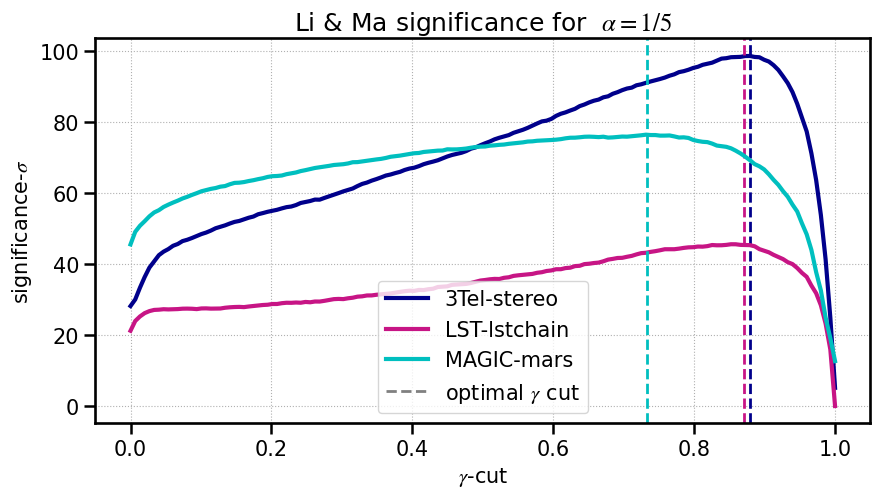

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Li & Ma significance for  $\\alpha=1/{n_regions_off}$')

for i in range(len(significance)):
    ax.plot(gamma_array, significance[i], label=label_df[i], c=cols[i], lw=3)
    ax.axvline(opt_gamma_s[i], color=cols[i], lw=2, linestyle='--')

ax.plot([], [], color='grey', lw=2, linestyle='--', label='optimal $\gamma$ cut')
ax.set_xlabel('$\gamma$-cut')
ax.set_ylabel('significance-$\sigma$')
ax.legend(loc=8)
ax.grid(ls=':')
plt.show()

# - Filtering by gamma dynamic ranges

In [10]:
gamma_cuts90, gamma_cuts68 = [] ,[]
num = []
for i in range(len(energy_bins)-1):
    
    df_tmp = df_mc_mean.query(f'reco_energy > {energy_bins[i]} & reco_energy < {energy_bins[i+1]}')
    
#     print(len(df_tmp))
    df_tmp = df_tmp.sort_values('gammaness', ascending=False)
    
    n_els = int(gh_efficiency1 * len(df_tmp)) 
    gamma_cut = df_tmp['gammaness'].to_numpy()[n_els]
    gamma_cuts90.append(gamma_cut)
    
    n_els = int(gh_efficiency2 * len(df_tmp))
    gamma_cut = df_tmp['gammaness'].to_numpy()[n_els]
    gamma_cuts68.append(gamma_cut)
    
    num.append(len(df_tmp))

num = np.array(num)

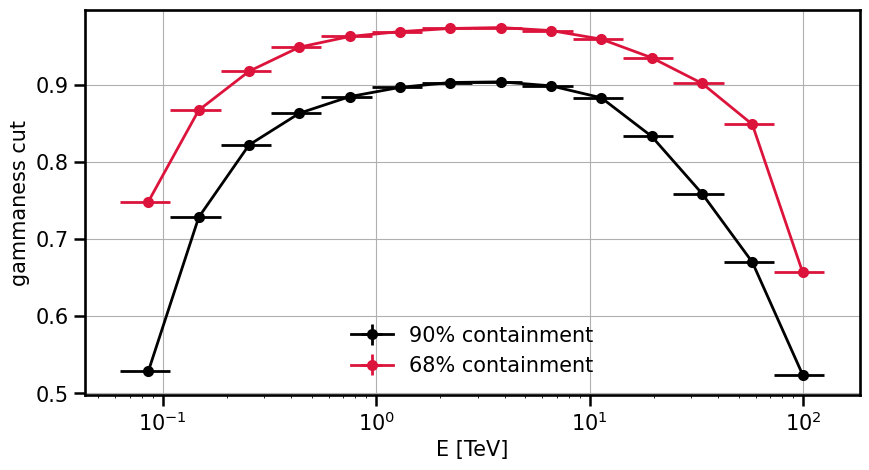

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(energy_bins_c, gamma_cuts90, xerr=energy_bins_width, yerr=np.std(gamma_cuts90)/np.sqrt(num), lw=2, color='k', marker='o', ls='-', label='90% containment')
ax.errorbar(energy_bins_c, gamma_cuts68, xerr=energy_bins_width, yerr=np.std(gamma_cuts68)/np.sqrt(num), lw=2, color='crimson', marker='o', ls='-', label='68% containment')


ax.legend(frameon=False)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('E [TeV]')
ax.set_ylabel('gammaness cut')
plt.show()

In [12]:
def dynamic_gamma_cuts(df, energy_bins, gamma_cuts):

    groups = df.groupby(pd.cut(df['reco_energy'], bins=energy_bins))
    
    filtered = []
    for i, (_, group) in zip(range(len(gamma_cuts)), groups):

        filtered.append(group.query(f'gammaness >= {gamma_cuts[i]}'))

    df_filt = pd.concat(filtered)

    return df_filt

# we can apply this cuts to the datasets so
df_mean_dyn  =  dynamic_gamma_cuts(df_mean, energy_bins, gamma_cuts90) 
df_lst_dyn   =  dynamic_gamma_cuts(df_lst, energy_bins, gamma_cuts90) 
df_magic_dyn =  dynamic_gamma_cuts(df_magic, energy_bins, gamma_cuts90)


# dynamic + same events
#############################
total_ids = df_mean_dyn['total_id'].to_numpy()

df_merged_tmp = df_merged.query(f'total_id in @total_ids')
total_magic_ids = df_merged_tmp['magic_id']

df_lst_dyn_coinc   = df_lst.query(f'total_id in @total_ids')
df_magic_dyn_coinc = df_magic.query(f'magic_id in @total_magic_ids')
#############################

# thetas of each dataframe filtered in gammaness
Ton_mean_dyn  = df_mean_dyn[ f'theta2_on'].to_numpy()
Ton_lst_dyn   = df_lst_dyn[  f'theta2_on'].to_numpy()
Ton_magic_dyn = df_magic_dyn[f'theta2_on'].to_numpy()
Ton_lst_dyn_coinc   = df_lst_dyn_coinc[  f'theta2_on'].to_numpy()
Ton_magic_dyn_coinc = df_magic_dyn_coinc[f'theta2_on'].to_numpy()

Toff_mean_dyn, Toff_lst_dyn, Toff_magic_dyn, Toff_lst_dyn_coinc, Toff_magic_dyn_coinc = [], [], [], [], []
for n in range(n_regions_off):
    Toff_mean_dyn.append( df_mean_dyn[ f'theta2_off{n+1}'].to_numpy())
    Toff_lst_dyn.append(  df_lst_dyn[  f'theta2_off{n+1}'].to_numpy())
    Toff_magic_dyn.append(df_magic_dyn[f'theta2_off{n+1}'].to_numpy())
    Toff_lst_dyn_coinc.append(  df_lst_dyn_coinc[  f'theta2_off{n+1}'].to_numpy())
    Toff_magic_dyn_coinc.append(df_magic_dyn_coinc[f'theta2_off{n+1}'].to_numpy())


In [13]:
compute = False

gamma_array_log = gamma_array # np.array([0, *(1-np.geomspace(1, 0.001, 60))])


if compute:
    dfs_dyn_coinc    = [df_mean_dyn.copy(), df_lst_dyn_coinc.copy(), df_magic_dyn_coinc.copy()]
    n_ons_dyn_coinc  = [[] for _ in dfs_dyn_coinc]
    n_offs_dyn_coinc = [[] for _ in dfs_dyn_coinc]

    tmp_dfs = dfs_dyn_coinc.copy()

    for g in range(len(gamma_array_log)):

        if g % 20 == 0:
            print(f'Computing {g / len(gamma_array_log) * 100:.0f}%...')

        tmp_dfs[0].query(f'gammaness >= {gamma_array_log[g]}', inplace=True)

        total_ids = tmp_dfs[0]['total_id'].to_numpy()

        df_merged_tmp = df_merged.query(f'total_id in @total_ids')
        total_magic_ids = df_merged_tmp['magic_id']

        tmp_dfs[1].query(f'total_id in @total_ids', inplace=True)
        tmp_dfs[2].query(f'magic_id in @total_magic_ids', inplace=True)


        for i in range(len(dfs_dyn_coinc)):

            n_on  = sum(tmp_dfs[i]['theta2_on' ] < theta2_cut)
            n_off = sum([sum(tmp_dfs[i][f'theta2_off{j+1}'] < theta2_cut) for j in range(n_regions_off)])

            n_offs_dyn_coinc[i].append(n_off)
            n_ons_dyn_coinc[i].append(n_on)
            
    n_offs_dyn_coinc = np.array(n_offs_dyn_coinc)
    n_ons_dyn_coinc  = np.array(n_ons_dyn_coinc)
    
    np.savetxt(f'{root_data}data/n_offs_dyn_coinc.txt', n_offs_dyn_coinc)
    np.savetxt(f'{root_data}data/n_ons_dyn_coinc.txt',  n_ons_dyn_coinc)
    
else:
    n_offs_dyn_coinc = np.loadtxt(f'{root_data}data/n_offs_dyn_coinc.txt')
    n_ons_dyn_coinc  = np.loadtxt(f'{root_data}data/n_ons_dyn_coinc.txt')

## Event off vs event excess

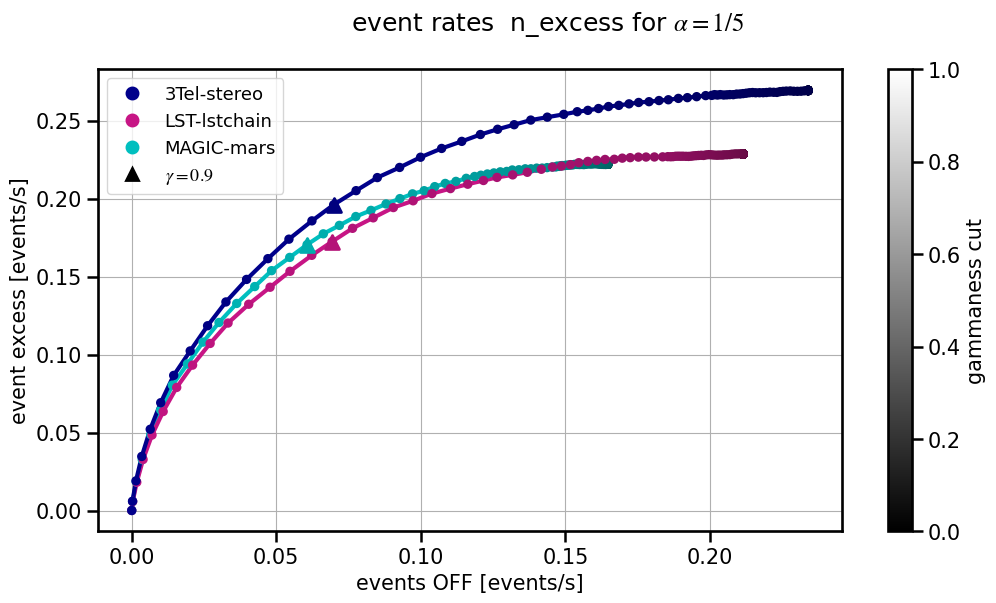

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle(f'event rates  n_excess for $\\alpha=1/{n_regions_off}$')

for i in np.flip(range(len(n_offs_dyn_coinc))):
    
    cmap = aux.create_cmap(['k', cols[i]])
    
    ax.plot(n_offs_dyn_coinc[i]/obs_time/n_regions_off, n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off, c=cols[i], lw=3, marker='', ls='-', zorder=1)
    
    ax.scatter((n_offs_dyn_coinc[i]/obs_time/n_regions_off), (n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off),
               c=gamma_array_log, lw=3, marker='o', cmap=cmap, s=14, zorder=200,)

    
gval = 0.9
for i in range(len(n_offs_dyn_coinc)):
    for g in range(len(gamma_array_log)-1):
        if gamma_array_log[g+1]>=gval and gamma_array_log[g]<gval:
            cmap = aux.create_cmap(['k', cols[i]])
            ax.scatter((n_offs_dyn_coinc[i]/obs_time/n_regions_off)[g+1], (n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off)[g+1],
                       c=gamma_array_log[g+1], cmap=cmap, marker='^', s=100, lw=2, zorder=200, norm=colors.Normalize(vmin=0, vmax=1))

    
for i in range(len(n_offs_dyn_coinc)):
    ax.plot([], [], c=cols[i], label=label_df[i], marker='o', ls='', ms=8) 
ax.plot([], [], c='k', label='$\gamma = 0.9$', marker='^', ls='', ms=8) 
    
cmap = aux.create_cmap(['k', 'w'])
    
sc = ax.scatter(n_offs_dyn_coinc[i]/obs_time/n_regions_off, n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off, c=gamma_array_log,
                s=0, lw=3, marker='o', cmap=cmap)

fig.colorbar(sc, ax=ax, label='gammaness cut', cmap='plasma')
    
ax.set_ylabel('event excess [events/s]')
ax.set_xlabel('events OFF [events/s]')

ax.legend(loc=2, fontsize=13)
# fig.tight_layout()
# plt.yscale('log')
ax.grid(True, zorder=-10)
[line.set_zorder(10) for line in ax.lines]

plt.show()

## Total theta plots

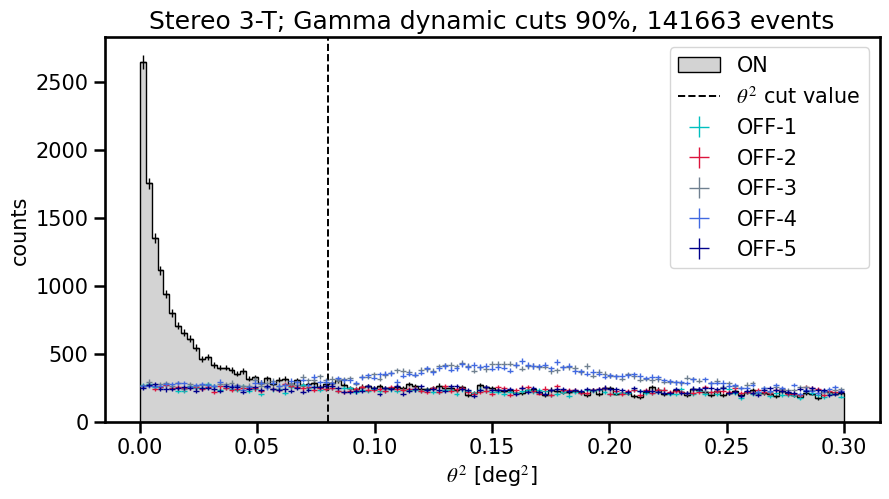

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Stereo 3-T; Gamma dynamic cuts 90%, {len(df_mean_dyn)} events')

hist_on, _, _ = ax.hist(Ton_mean_dyn, bins=theta2_bins, color='lightgrey', edgecolor='k', alpha=1, histtype='stepfilled', label='ON')
plt.errorbar(theta2_bins_c, hist_on, xerr=theta2_bins_width, yerr=np.sqrt(hist_on), fmt='.', ms=0, color='k', zorder=10, lw=1)


for i in range(n_regions_off):
    hist_off, _ = np.histogram(Toff_mean_dyn[i], bins=theta2_bins)
    plt.errorbar(theta2_bins_c, hist_off, xerr=theta2_bins_width, yerr=np.sqrt(hist_off), fmt='.', ms=0, color=colors_off[i], zorder=10, lw=1, 
                label=f'OFF-{i+1}')

ax.axvline(theta2_cut, color='k', lw=1.4, ls='--', label='$\\theta^2$ cut value')
ax.set_xlabel('$\\theta^2$ [deg$^2$]')
ax.set_ylabel('counts')
ax.legend(loc=1)
plt.show()

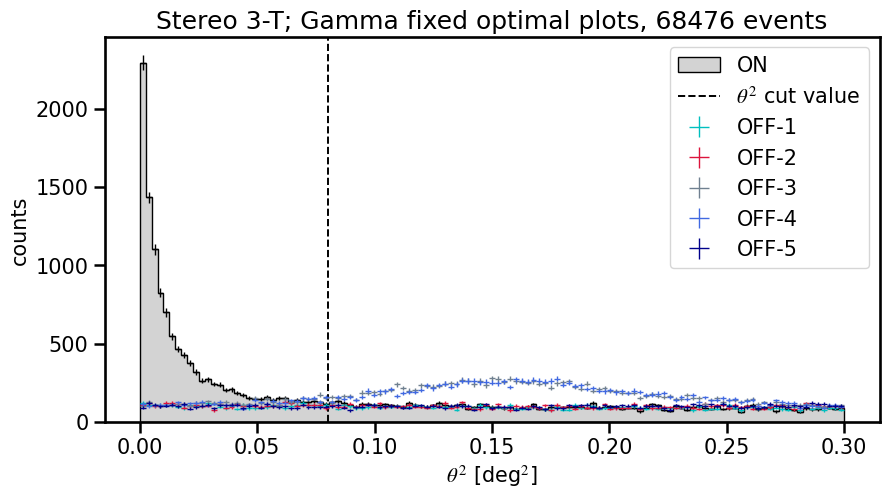

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Stereo 3-T; Gamma fixed optimal plots, {len(df_mean_fix)} events')

hist_on, _, _ = ax.hist(df_mean_fix[ f'theta2_on'], bins=theta2_bins, color='lightgrey', edgecolor='k', alpha=1, histtype='stepfilled', label='ON')
plt.errorbar(theta2_bins_c, hist_on, xerr=theta2_bins_width, yerr=np.sqrt(hist_on), fmt='.', ms=0, color='k', zorder=10, lw=1)


for i in range(n_regions_off):
    
    Toff_tmp = df_mean_fix[ f'theta2_off{i+1}'].to_numpy()
    
    hist_off, _ = np.histogram(Toff_tmp, bins=theta2_bins)
    plt.errorbar(theta2_bins_c, hist_off, xerr=theta2_bins_width, yerr=np.sqrt(hist_off), fmt='.', ms=0, color=colors_off[i], zorder=10, lw=1, 
                label=f'OFF-{i+1}')

ax.axvline(theta2_cut, color='k', lw=1.4, ls='--', label='$\\theta^2$ cut value')
ax.set_xlabel('$\\theta^2$ [deg$^2$]')
ax.set_ylabel('counts')
ax.legend(loc=1)
plt.show()

## Energy binned theta plot

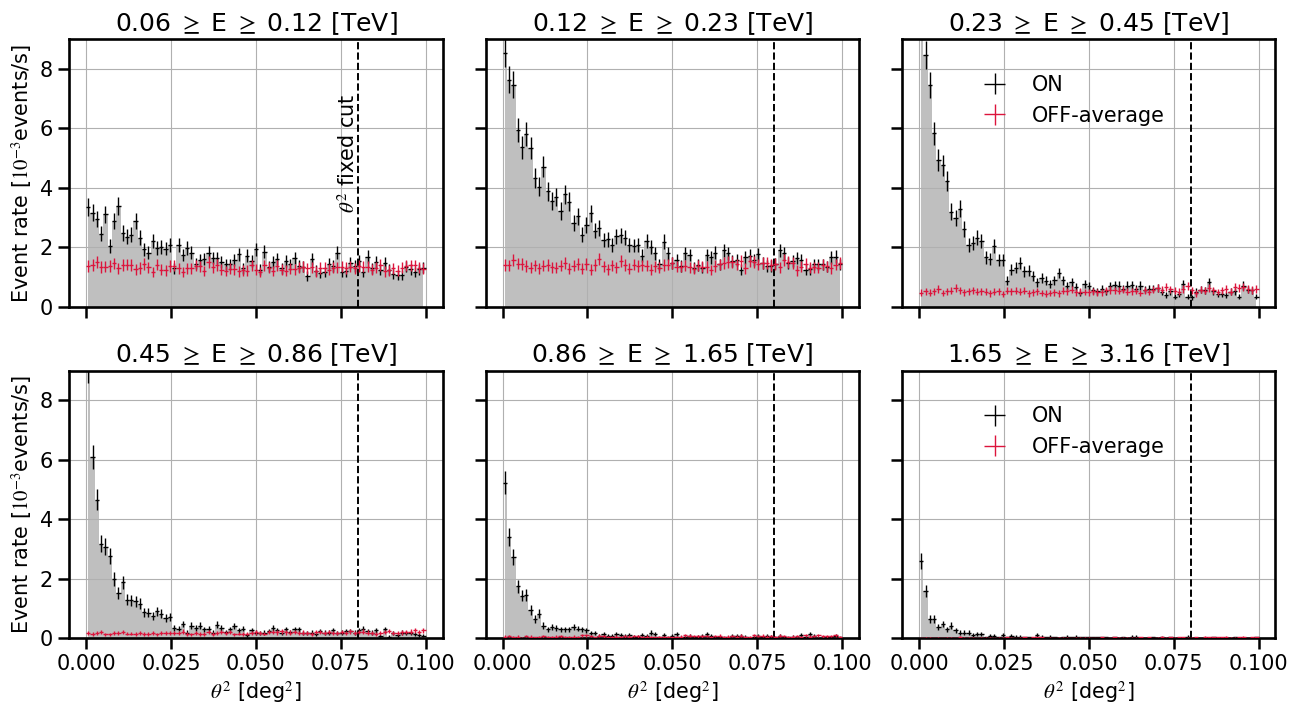

In [17]:
n_columns = 2
n_rows = int(np.ceil(len(energy_bins_multiplot[:-1]) / n_columns))
grid = (n_columns, n_rows)

fig, ax = plt.subplots(*grid, figsize=(n_rows * 4.4, 7.4), sharey=True, sharex=True)

axes = [ax[i][j] for i in range(len(ax)) for j in range(len(ax[i]))]

for i in range(len(energy_bins_multiplot)-1):
    
    df_events = df_mean_dyn.query(f'(reco_energy >= {energy_bins_multiplot[i]}) & (reco_energy <= {energy_bins_multiplot[i+1]})')
    
    
#     hist_on, _, _ = axes[i].hist(df_events['theta2_on'], bins=theta2_bins, histtype='bar', linewidth=2, alpha=0.5, color='gray')
    
    hist_on, _ = np.histogram(df_events['theta2_on'], bins=theta2_bins_short)
    axes[i].fill_between(theta2_bins_short_c, hist_on/obs_time*1e3, color='gray', alpha=0.5, edgecolor='none', step='mid')


    axes[i].errorbar(theta2_bins_short_c, hist_on/obs_time*1e3, xerr=theta2_bins_short_width, yerr=np.sqrt(hist_on)/obs_time*1e3,
                     fmt='.', ms=0, color='k', zorder=10, lw=1, label='ON')
    
    hists_off = []
    for j in range(n_regions_off):
        hist_off, _ = np.histogram(df_events[f'theta2_off{j+1}'], bins=theta2_bins_short)
        hists_off.append(hist_off)
        
    hist_off_avg = sum(hists_off)/n_regions_off
    
    axes[i].errorbar(theta2_bins_short_c, hist_off_avg/obs_time*1e3, xerr=theta2_bins_short_width, yerr=np.sqrt(hist_off_avg)/obs_time*1e3, 
                     fmt='.', ms=0, color='crimson', zorder=10, lw=1, 
                label=f'OFF-average')
    
    axes[i].set_title(f'{energy_bins_multiplot[i]:.2f} $\geq$ E $\geq$ {energy_bins_multiplot[i+1]:.2f} [TeV]')
    axes[i].grid()
    axes[i].axvline(0.08, color='k', lw=1.4, ls='--')

axes[0].text(0.074, 3.3, '$\\theta^2$ fixed cut', rotation=90, )
    
for i in range(3):
    ax[0][i].set_ylim(0, 9)
    ax[1][i].set_ylim(0, 9)

for i in range(len(ax)):
    ax[i][0].set_ylabel('Event rate [$10^{-3}$events/s]')
    ax[i][2].legend(loc=(0.17, 0.646), frameon=False)
for i in range(len(ax[-1])):
    ax[-1][i].set_xlabel('$\\theta^2$ [deg${}^2$]')
# for i in range(len(axes)):
#     axes[i].set_ylim(bottom=0)

fig.tight_layout()

plt.show()

## Angular resolution

In [18]:
def compute_angres(dfs):
    
    angres = []
    for df, theta2_c in zip(dfs, theta2_cuts):

        #get event theta value
        theta2vec = df['theta2_on']
        thetavec  = np.sqrt(theta2vec)

        #add theta value to dataframe and get a QTable from it
        df.loc[:,'theta'] = u.Quantity(thetavec, u.deg)

        # apply global theta cut to events
        df_table = QTable.from_pandas(df)
        mask = df_table['theta'].value < np.repeat(np.sqrt(theta2_c), (len(df_table)))
        df_table = df_table[mask] 

        df_table['reco_energy'] = u.Quantity(df_table['reco_energy'], u.TeV)

        #angular resolution
        angres_table = angular_resolution(df_table, u.Quantity(energy_bins_angres, u.TeV), energy_type='reco')
        angres.append(angres_table['angular_resolution'].value)

    
    return angres

angres_dyn = compute_angres([df_mean_dyn.copy(), df_lst_dyn.copy(), df_magic_dyn.copy()])
angres_fix = compute_angres([df_mean_fix.copy(), df_lst_fix.copy(), df_magic_fix.copy()])

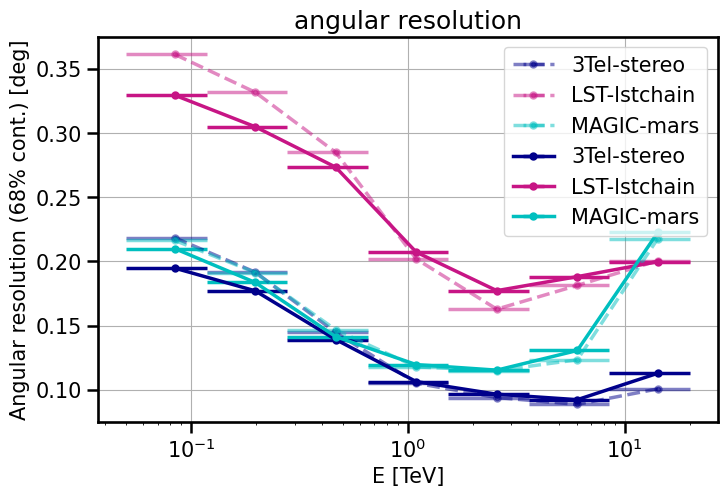

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

plt.title(f'angular resolution')
plt.ylabel('Angular resolution (68% cont.) [deg]')
plt.xlabel('E [TeV]')
plt.semilogx()
plt.grid()

for i in range(len(angres_dyn)):
    ax.errorbar(x=energy_bins_angres_c, y=angres_dyn[i], xerr=energy_bins_angres_width, label=label_df[i], marker='o', color=cols[i], lw=2.5, ms=4, ls='--', alpha=0.5)
for i in range(len(angres_fix)):
    ax.errorbar(x=energy_bins_angres_c, y=angres_fix[i], xerr=energy_bins_angres_width, label=label_df[i], marker='o', color=cols[i], lw=2.5, ms=4)
ax.legend()
plt.show()

### Significance Sensitivity
We can calculate it for:
* E < 200 GeV
* E > 200 GeV

In [20]:
def compute_sensitivity(gamma_array, theta2_array, df_input ,energy_range, nhours=50, energy_lim=0.3):
    
    if energy_range == 'top':
        top_bott = '>'        
    elif energy_range == 'bottom':
        top_bott = '<'
        
    time_factor = nhours / (obs_time / 3600)
    
    df = df_input.copy().query(f'reco_energy {top_bott}= {energy_lim}', inplace=False)
    
    vector_li_ma = np.vectorize(li_ma_significance)
    
    G, T = np.meshgrid(gamma_array, theta2_array)
    
    
    N_off, N_on = np.zeros_like(G), np.zeros_like(G) 
    
    for g in range(len(gamma_array)):
        
        if g%15 == 0:
            print(f'Counting ON-OFF {g/len(gamma_array)*100:.1f}%...')
            
        df_gamma = df.query(f'gammaness > {gamma_array[g]}')
        
        theta2_on_filtered  = df_gamma['theta2_on'].to_numpy()
        theta2_off_filtered = np.array([df_gamma[f'theta2_off{j+1}'].to_numpy() for j in range(n_regions_off)])
        N_on[g] = np.sum(theta2_on_filtered[:, None] < theta2_array, axis=0)
        N_off[g] = np.sum(np.sum(theta2_off_filtered[:, :, None] < theta2_array, axis=0), axis=0)
    
    return vector_li_ma(N_on, N_off, 1. / n_regions_off).T

In [21]:
compute = False
Nbins   = 150
gamma_array_sigmas  = np.linspace(0, 1   , Nbins)
theta2_array_sigmas = np.linspace(0, 0.13, Nbins)

Gamma_mesh, Theta2_mesh = np.meshgrid(gamma_array_sigmas, theta2_array_sigmas)

if compute:
    
    sigma_top_mean     = compute_sensitivity(gamma_array_sigmas, theta2_array_sigmas, df_mean,  'top')
    sigma_bottom_mean  = compute_sensitivity(gamma_array_sigmas, theta2_array_sigmas, df_mean,  'bottom')
    sigma_top_lst      = compute_sensitivity(gamma_array_sigmas, theta2_array_sigmas, df_lst,   'top')
    sigma_bottom_lst   = compute_sensitivity(gamma_array_sigmas, theta2_array_sigmas, df_lst,   'bottom')
    sigma_top_magic    = compute_sensitivity(gamma_array_sigmas, theta2_array_sigmas, df_magic, 'top')
    sigma_bottom_magic = compute_sensitivity(gamma_array_sigmas, theta2_array_sigmas, df_magic, 'bottom')
    
    np.savetxt(f'{root_data}data/sigma_top_mean.txt', sigma_top_mean)
    np.savetxt(f'{root_data}data/sigma_bottom_mean.txt', sigma_bottom_mean)

    np.savetxt(f'{root_data}data/sigma_top_lst.txt', sigma_top_lst)
    np.savetxt(f'{root_data}data/sigma_bottom_lst.txt', sigma_bottom_lst)

    np.savetxt(f'{root_data}data/sigma_top_magic.txt', sigma_top_magic)
    np.savetxt(f'{root_data}data/sigma_bottom_magic.txt', sigma_bottom_magic)

else:
    sigma_top_mean     = np.loadtxt(f'{root_data}data/sigma_top_mean.txt')
    sigma_bottom_mean  = np.loadtxt(f'{root_data}data/sigma_bottom_mean.txt')
    sigma_top_lst      = np.loadtxt(f'{root_data}data/sigma_top_lst.txt')
    sigma_bottom_lst   = np.loadtxt(f'{root_data}data/sigma_bottom_lst.txt')
    sigma_top_magic    = np.loadtxt(f'{root_data}data/sigma_top_magic.txt')
    sigma_bottom_magic = np.loadtxt(f'{root_data}data/sigma_bottom_magic.txt')
    
    sigma_top    = [sigma_top_mean, sigma_top_lst, sigma_top_magic]
    sigma_bottom = [sigma_bottom_mean, sigma_bottom_lst, sigma_bottom_magic]

In [22]:
# extracting optimal values
max_indices_top_mean  = np.unravel_index(np.argmax(sigma_top_mean),  sigma_top_mean.shape)
max_indices_top_lst   = np.unravel_index(np.argmax(sigma_top_lst),   sigma_top_lst.shape)
max_indices_top_magic = np.unravel_index(np.argmax(sigma_top_magic), sigma_top_magic.shape)

max_indices_bottom_mean  = np.unravel_index(np.argmax(sigma_bottom_mean),  sigma_bottom_mean.shape)
max_indices_bottom_lst   = np.unravel_index(np.argmax(sigma_bottom_lst),   sigma_bottom_lst.shape)
max_indices_bottom_magic = np.unravel_index(np.argmax(sigma_bottom_magic), sigma_bottom_magic.shape)


# Retrieve the corresponding x and y values for each Z matrix
gamma_opt_top_mean  = Gamma_mesh[max_indices_top_mean]
gamma_opt_top_lst   = Gamma_mesh[max_indices_top_lst]
gamma_opt_top_magic = Gamma_mesh[max_indices_top_magic]

gamma_opt_bottom_mean  = Gamma_mesh[max_indices_bottom_mean]
gamma_opt_bottom_lst   = Gamma_mesh[max_indices_bottom_lst]
gamma_opt_bottom_magic = Gamma_mesh[max_indices_bottom_magic]

theta2_opt_top_mean  = Theta2_mesh[max_indices_top_mean]
theta2_opt_top_lst   = Theta2_mesh[max_indices_top_lst]
theta2_opt_top_magic = Theta2_mesh[max_indices_top_magic]

theta2_opt_bottom_mean  = Theta2_mesh[max_indices_bottom_mean]
theta2_opt_bottom_lst   = Theta2_mesh[max_indices_bottom_lst]
theta2_opt_bottom_magic = Theta2_mesh[max_indices_bottom_magic]

opt_top    = [[gamma_opt_top_mean, theta2_opt_top_mean], [gamma_opt_top_lst, theta2_opt_top_lst], [gamma_opt_top_magic, theta2_opt_top_magic]]
opt_bottom = [[gamma_opt_bottom_mean, theta2_opt_bottom_mean], [gamma_opt_bottom_lst, theta2_opt_bottom_lst], [gamma_opt_bottom_magic, theta2_opt_bottom_magic]]

opt_top = [[gamma_opt_top_mean, theta2_opt_top_mean], [gamma_opt_top_lst, theta2_opt_top_lst], [gamma_opt_top_magic, theta2_opt_top_magic]]

slice_opt_top    = [sigma_top_mean[:, max_indices_top_mean[0]], sigma_top_lst[:, max_indices_top_lst[0]], sigma_top_magic[:, max_indices_top_magic[0]]]
slice_opt_bottom = [sigma_bottom_mean[:, max_indices_bottom_mean[0]], sigma_bottom_lst[:, max_indices_bottom_lst[0]], sigma_bottom_magic[:, max_indices_bottom_magic[0]]]


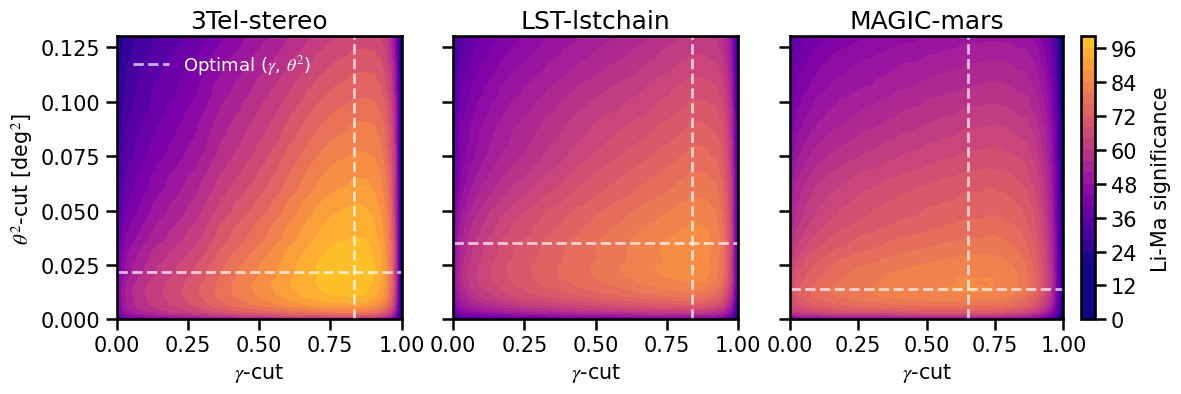

In [23]:
cmap = 'plasma'
levels = 30
vmax = 110
vmin = 20

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.2), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.2]})
axes = [ax1, ax2, ax3] 

sigmas = sigma_top

for m in range(len(sigmas)):
    if m == 0:
        cf = axes[m].contourf(gamma_array_sigmas, theta2_array_sigmas, sigmas[m], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    else:
        axes[m].contourf(gamma_array_sigmas, theta2_array_sigmas, sigmas[m], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    axes[m].axvline(opt_top[m][0], color='w', lw=2, alpha=0.7, ls='--')
    axes[m].axhline(opt_top[m][1], color='w', lw=2, alpha=0.7, ls='--')
    
    axes[m].set_title(label_df[m])
    
cb = fig.colorbar(cf, ax=ax3)
cb.set_label('Li-Ma significance', labelpad=10)

ax1.plot([],[], color='w', lw=2, alpha=0.7, ls='--', label='Optimal ($\gamma$, $\\theta^2$)')
ax1.legend(frameon=False, fontsize=13, labelcolor='w')

for ax, t in zip(axes, label_df):
    ax.set_xlabel('$\gamma$-cut')
ax1.set_ylabel('$\\theta^2$-cut [deg${}^2$]')

fig.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0)

plt.savefig(f'{pltpath}optimal-gamma-theta.png', bbox_inches='tight', dpi=dpi)

plt.show()

## Now we calculate the significance with this cuts

In [24]:
def calculate_sensitivity(df, theta2_cut, gamma_opt, nhours=50, energy_lim=0.3):

    time_factor = nhours / (obs_time / 3600)
    df = df.query(f'gammaness > {gamma_opt}', inplace=False)
    
    S = []
    for i in range(len(energy_bins_sens)-1):
        
        tmp_df = df.copy().query(f'reco_energy > {energy_bins_sens[i]} & reco_energy < {energy_bins_sens[i+1]}')
        
        if i%1 == 0:
            print(f'\nEnergy bin {i+1}: {energy_bins_sens[i]:.2f} < E < {energy_bins_sens[i+1]:.2f} TeV:')
        
        n_on  = sum(tmp_df['theta2_on' ] < theta2_cut)
        n_off = sum([sum(tmp_df[f'theta2_off{j+1}'] < theta2_cut) for j in range(n_regions_off)])
            
        
        def sig5sigma(C, n_on, n_off):
            return li_ma_significance(time_factor*(n_off/n_regions_off + C * (n_on-n_off/n_regions_off)), time_factor * n_off, 1./n_regions_off)-5
        
        r = aux.RootFinder(0, 3, 0.001)
        args = (n_on, n_off)
        roots = r.find(sig5sigma, *args)
        
        
        print(f'--> timefactor * n_excess\t= {time_factor*(n_on - n_off / n_regions_off):.2f}')
        print(f'--> n_excess/n_off\t\t= {(n_on - n_off / n_regions_off) / n_off:.2f}')

        if len(roots) > 0:
            S.append(roots[0]*100)
        else:
            S.append(np.nan)
            
    return S

In [25]:
compute = False

if compute:
    
    sens_mean  = calculate_sensitivity(df_mean,  theta2_opt_top_mean,  gamma_opt_top_mean)
    sens_lst   = calculate_sensitivity(df_lst,   theta2_opt_top_lst,   gamma_opt_top_lst)
    sens_magic = calculate_sensitivity(df_magic, theta2_opt_top_magic, gamma_opt_top_magic)
    
    np.savetxt(f'{root_data}data/sens_mean.txt', sens_mean)
    np.savetxt(f'{root_data}data/sens_lst.txt', sens_lst)
    np.savetxt(f'{root_data}data/sens_magic.txt', sens_magic)

else:
    sens_mean  = np.loadtxt(f'{root_data}data/sens_mean.txt')
    sens_lst   = np.loadtxt(f'{root_data}data/sens_lst.txt')
    sens_magic = np.loadtxt(f'{root_data}data/sens_magic.txt')


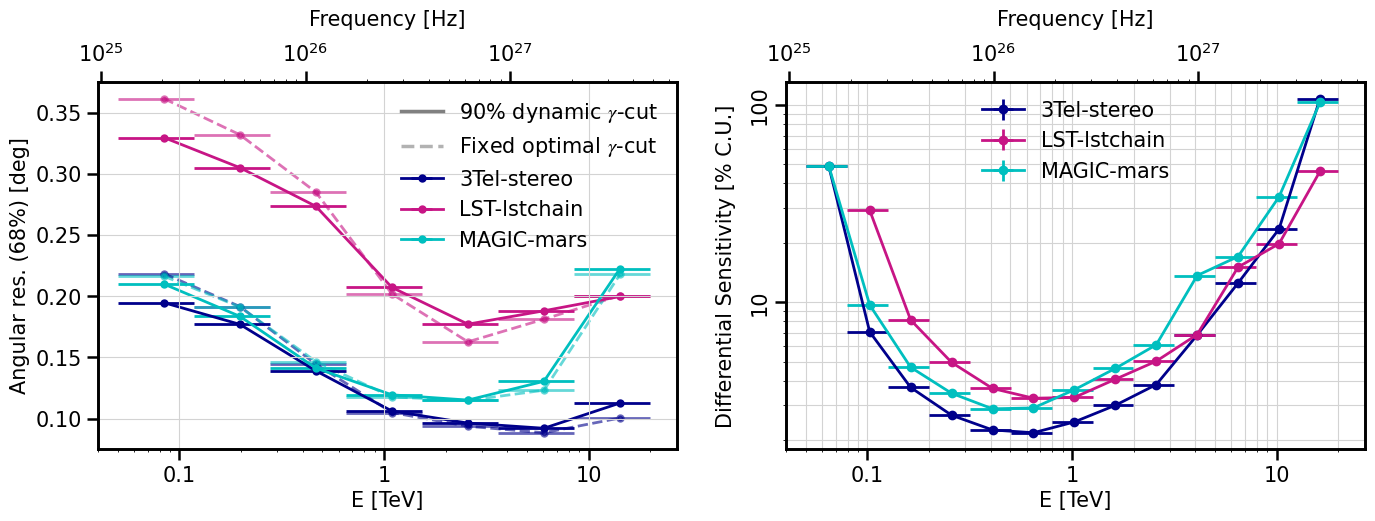

In [26]:
kw = dict(lw=2, ls='-', marker='.', ms=10, yerr=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5.5))

for i in range(len(angres_dyn)):
    ax1.errorbar(x=energy_bins_angres_c, y=angres_dyn[i], xerr=energy_bins_angres_width, marker='o', color=cols[i], lw=2, ms=4, ls='--', alpha=0.6, zorder=0)
for i in range(len(angres_fix)):
    ax1.errorbar(x=energy_bins_angres_c, y=angres_fix[i], xerr=energy_bins_angres_width, label=label_df[i], marker='o', color=cols[i], lw=2, ms=4, zorder=1)

ax2.errorbar(energy_bins_sens_c, sens_mean,  xerr=energy_bins_sens_width, **kw, c=cols[0], label=label_df[0])
ax2.errorbar(energy_bins_sens_c, sens_lst,   xerr=energy_bins_sens_width, **kw, c=cols[1], label=label_df[1])
ax2.errorbar(energy_bins_sens_c, sens_magic, xerr=energy_bins_sens_width, **kw, c=cols[2], label=label_df[2])
    
    
ax1.set_ylabel('Angular res. (68%) [deg]')
ax2.set_ylabel('Differential Sensitivity [% C.U.]', labelpad=10)
ax1.set_xlabel('E [TeV]')
ax2.set_xlabel('E [TeV]')
ax1.set_xscale('log')
ax2.loglog()
ax1.grid(color='lightgray')
ax2.grid(which='both', color='lightgray')

ax1.plot([], [], marker='', color='gray', lw=2.5, ms=4, label='90% dynamic $\gamma$-cut')
ax1.plot([], [], marker='', lw=2.5, ms=4, ls='--', alpha=0.6, color='gray', label='Fixed optimal $\gamma$-cut')
ax1.legend(frameon=False)

axt1 = ax1.twiny()
axt1.set_xlabel('Frequency [Hz]', labelpad=12)
xlimsE = np.array([0.04, 27])
ax1.set_xlim(*xlimsE)
xlimsV = xlimsE * 2.418e14 * 1e12
axt1.set_xlim(*xlimsV)
axt1.set_xscale('log')

axt2 = ax2.twiny()
axt2.set_xlabel('Frequency [Hz]', labelpad=12)
xlimsE = np.array([0.04, 27])
ax2.set_xlim(*xlimsE)
xlimsV = xlimsE * 2.418e14 * 1e12
axt2.set_xlim(*xlimsV)
axt2.set_xscale('log')
fig.tight_layout()
ax2.legend(frameon=False)

ax2.yaxis.set_tick_params(rotation=90)

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
for label in ax2.get_yticklabels():
    label.set_va('center')

    
# plt.savefig(f'{pltpath}angres-and-sens.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

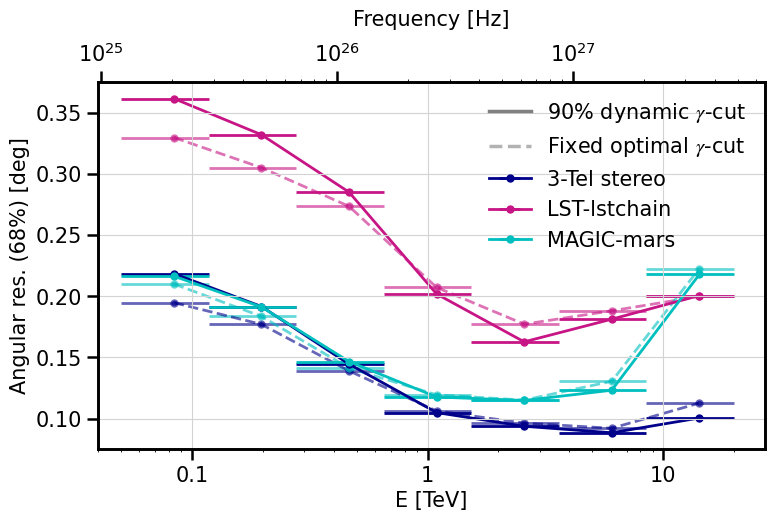

In [53]:
kw = dict(lw=2, ls='-', marker='.', ms=10, yerr=0)

fig, (ax1) = plt.subplots(figsize=(8,5.5))

for i in range(len(angres_dyn)):
    ax1.errorbar(x=energy_bins_angres_c, y=angres_fix[i], xerr=energy_bins_angres_width, marker='o', color=cols[i], lw=2, ms=4, ls='--', alpha=0.6, zorder=0)
for i in range(len(angres_fix)):
    ax1.errorbar(x=energy_bins_angres_c, y=angres_dyn[i], xerr=energy_bins_angres_width, label=label_df[i], marker='o', color=cols[i], lw=2, ms=4, zorder=1)

ax2.errorbar(energy_bins_sens_c, sens_mean,  xerr=energy_bins_sens_width, **kw, c=cols[0], label=label_df[0])
ax2.errorbar(energy_bins_sens_c, sens_lst,   xerr=energy_bins_sens_width, **kw, c=cols[1], label=label_df[1])
ax2.errorbar(energy_bins_sens_c, sens_magic, xerr=energy_bins_sens_width, **kw, c=cols[2], label=label_df[2])
    
    
ax1.set_ylabel('Angular res. (68%) [deg]')
ax2.set_ylabel('Differential Sensitivity [% C.U.]', labelpad=10)
ax1.set_xlabel('E [TeV]')
ax2.set_xlabel('E [TeV]')
ax1.set_xscale('log')
ax2.loglog()
ax1.grid(color='lightgray')
ax2.grid(which='both', color='lightgray')

ax1.plot([], [], marker='', color='gray', lw=2.5, ms=4, label='90% dynamic $\gamma$-cut')
ax1.plot([], [], marker='', lw=2.5, ms=4, ls='--', alpha=0.6, color='gray', label='Fixed optimal $\gamma$-cut')
ax1.legend(frameon=False)

axt1 = ax1.twiny()
axt1.set_xlabel('Frequency [Hz]', labelpad=12)
xlimsE = np.array([0.04, 27])
ax1.set_xlim(*xlimsE)
xlimsV = xlimsE * 2.418e14 * 1e12
axt1.set_xlim(*xlimsV)
axt1.set_xscale('log')

axt2 = ax2.twiny()
axt2.set_xlabel('Frequency [Hz]', labelpad=12)
xlimsE = np.array([0.04, 27])
ax2.set_xlim(*xlimsE)
xlimsV = xlimsE * 2.418e14 * 1e12
axt2.set_xlim(*xlimsV)
axt2.set_xscale('log')
fig.tight_layout()
ax2.legend(frameon=False)

ax2.yaxis.set_tick_params(rotation=90)

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
for label in ax2.get_yticklabels():
    label.set_va('center')

    
plt.savefig(f'{pltpath}angres-and-sens.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

In [28]:
angres_fix[2]-angres_fix[0]

array([0.01524649, 0.00653519, 0.00223849, 0.01322677, 0.01877342,
       0.03836266, 0.10979823])

In [29]:
energy_bins_angres_c

array([ 0.08399779,  0.19755883,  0.46464901,  1.09283247,  2.57029022,
        6.04520085, 14.21802607])

In [30]:
energy_bins_angres

array([ 0.05011872,  0.11787686,  0.2772408 ,  0.65205723,  1.53360772,
        3.60697272,  8.48342898, 19.95262315])

In [31]:
angres_dyn[0], np.min(angres_dyn[0])

(array([0.2184526 , 0.19162443, 0.14459559, 0.10503737, 0.09384472,
        0.08854294, 0.1006117 ]),
 0.08854294001405377)

In [32]:
angres_dyn[1], np.min(angres_dyn[1])

(array([0.36142657, 0.33189217, 0.28501104, 0.20186532, 0.16278481,
        0.18128892, 0.20057503]),
 0.16278480890721736)

In [33]:
angres_dyn[2], np.min(angres_dyn[2])

(array([0.21640207, 0.19128742, 0.14668115, 0.11776637, 0.11491449,
        0.12327962, 0.21778174]),
 0.11491448732326534)

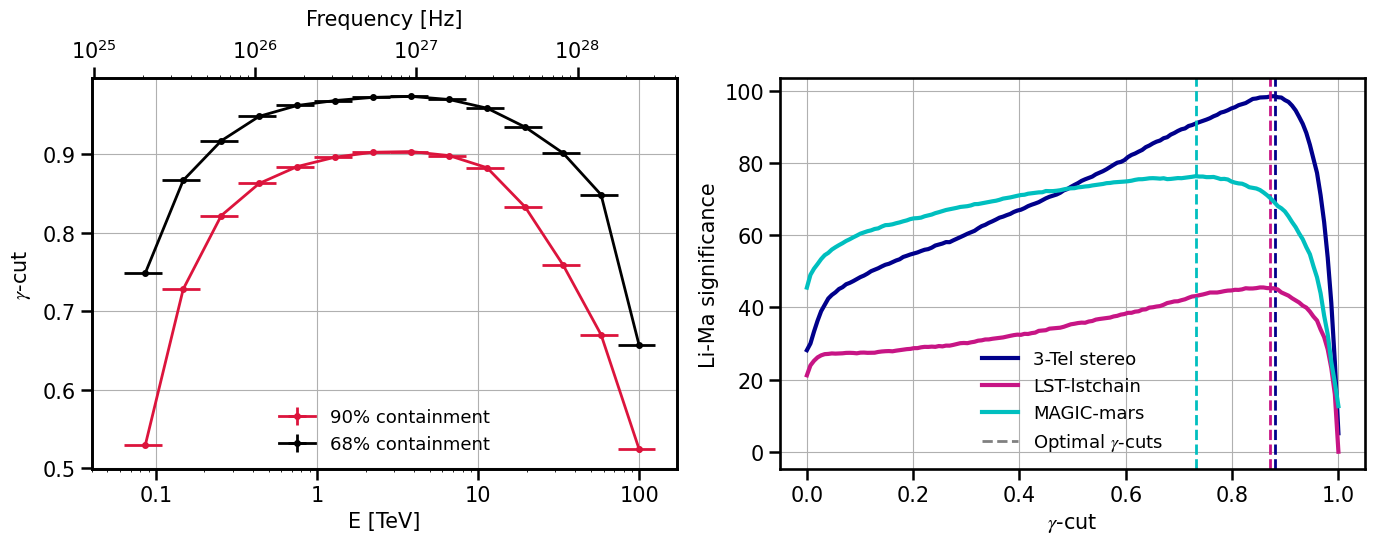

In [58]:
label_df = ['3-Tel stereo', 'LST-lstchain', 'MAGIC-mars']

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(14, 5.7))
# ax1.text(0.04, 95, f'$\\alpha=1/{n_regions_off}$', ha='center', va='center', fontsize=18)

for i in range(len(significance)):
    ax1.plot(gamma_array, significance[i], label=label_df[i], c=cols[i], lw=3)
    ax1.axvline(opt_gamma_s[i], color=cols[i], lw=2, linestyle='--')

ax1.plot([], [], color='grey', lw=2, linestyle='--', label='Optimal $\gamma$-cuts')
ax1.set_xlabel('$\gamma$-cut')
ax1.set_ylabel('Li-Ma significance')
ax1.legend(loc=8, frameon=False, fontsize=13)
ax1.grid()


ax2.errorbar(energy_bins_c, gamma_cuts90, xerr=energy_bins_width, yerr=np.std(gamma_cuts90)/np.sqrt(num), lw=2, color='crimson', marker='.', ls='-', label='90% containment')
ax2.errorbar(energy_bins_c, gamma_cuts68, xerr=energy_bins_width, yerr=np.std(gamma_cuts68)/np.sqrt(num), lw=2, color='k', marker='.', ls='-', label='68% containment')


ax2.legend(frameon=False, fontsize=13)
ax2.grid()
ax2.set_xscale('log')
ax2.set_xlabel('E [TeV]')
ax2.set_ylabel('$\gamma$-cut', labelpad=7)

ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


axt = ax2.twiny()
axt.set_xlabel('Frequency [Hz]', labelpad=10)
xlimsE = np.array([0.04, 170])
ax2.set_xlim(*xlimsE)
xlimsV = xlimsE * 2.418e14 * 1e12
axt.set_xlim(*xlimsV)
axt.set_xscale('log')


fig.tight_layout()

plt.savefig(f'{pltpath}optimal-gammaness.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

In [35]:
np.max(significance[0]), np.max(significance[1]), np.max(significance[2])

(98.5935201270874, 45.5576689324538, 76.42197102274805)

In [36]:
gamma_array[np.argmax(significance[0])], gamma_array[np.argmax(significance[1])], gamma_array[np.argmax(significance[2])]

(0.8791946308724832, 0.8523489932885906, 0.7315436241610738)

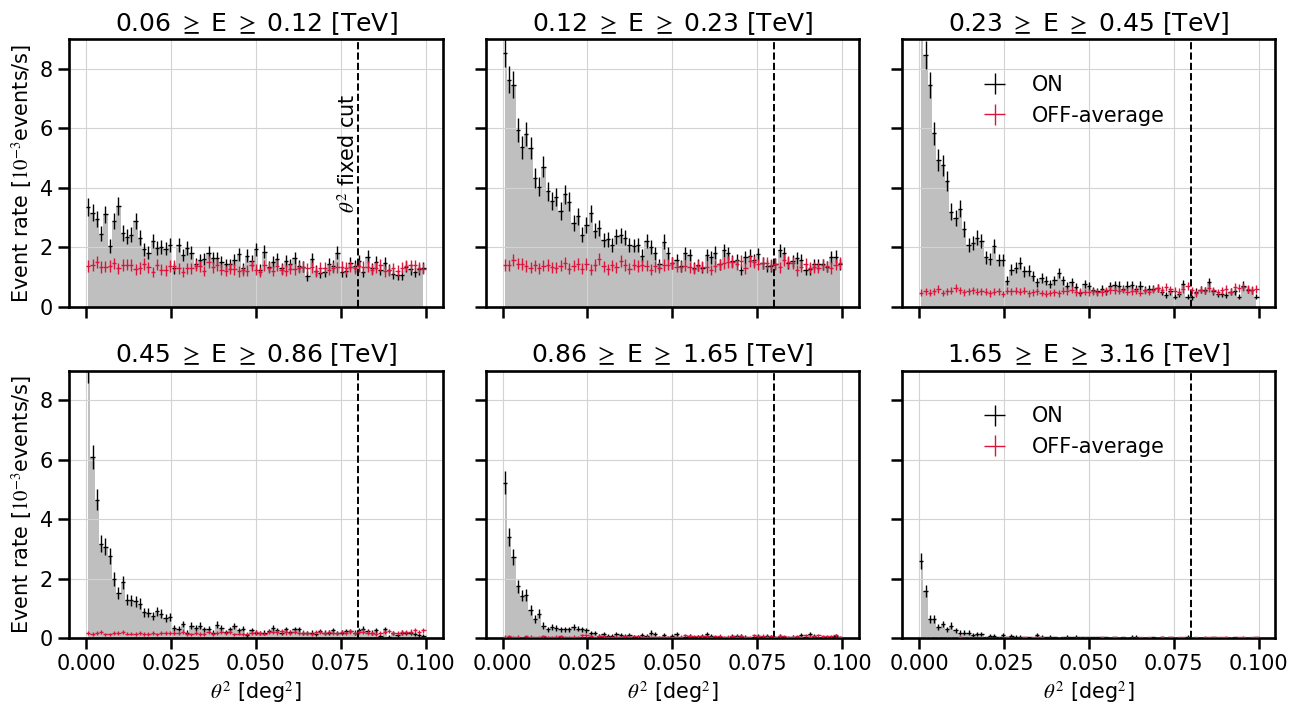

In [37]:
n_columns = 2
n_rows = int(np.ceil(len(energy_bins_multiplot[:-1]) / n_columns))
grid = (n_columns, n_rows)

fig, ax = plt.subplots(*grid, figsize=(n_rows * 4.4, 7.4), sharey=True, sharex=True)

axes = [ax[i][j] for i in range(len(ax)) for j in range(len(ax[i]))]

for i in range(len(energy_bins_multiplot)-1):
    
    df_events = df_mean_dyn.query(f'(reco_energy >= {energy_bins_multiplot[i]}) & (reco_energy <= {energy_bins_multiplot[i+1]})')
    
    
#     hist_on, _, _ = axes[i].hist(df_events['theta2_on'], bins=theta2_bins, histtype='bar', linewidth=2, alpha=0.5, color='gray')
    
    hist_on, _ = np.histogram(df_events['theta2_on'], bins=theta2_bins_short)
    axes[i].fill_between(theta2_bins_short_c, hist_on/obs_time*1e3, color='gray', alpha=0.5, edgecolor='none', step='mid')


    axes[i].errorbar(theta2_bins_short_c, hist_on/obs_time*1e3, xerr=theta2_bins_short_width, yerr=np.sqrt(hist_on)/obs_time*1e3,
                     fmt='.', ms=0, color='k', zorder=10, lw=1, label='ON')
    
    hists_off = []
    for j in range(n_regions_off):
        hist_off, _ = np.histogram(df_events[f'theta2_off{j+1}'], bins=theta2_bins_short)
        hists_off.append(hist_off)
        
    hist_off_avg = sum(hists_off)/n_regions_off
    
    axes[i].errorbar(theta2_bins_short_c, hist_off_avg/obs_time*1e3, xerr=theta2_bins_short_width, yerr=np.sqrt(hist_off_avg)/obs_time*1e3, 
                     fmt='.', ms=0, color='crimson', zorder=10, lw=1, 
                label=f'OFF-average')
    
    axes[i].set_title(f'{energy_bins_multiplot[i]:.2f} $\geq$ E $\geq$ {energy_bins_multiplot[i+1]:.2f} [TeV]')
    axes[i].grid(color='lightgray')
    axes[i].axvline(0.08, color='k', lw=1.4, ls='--')

axes[0].text(0.074, 3.3, '$\\theta^2$ fixed cut', rotation=90, )
    
for i in range(3):
    ax[0][i].set_ylim(0, 9)
    ax[1][i].set_ylim(0, 9)

for i in range(len(ax)):
    ax[i][0].set_ylabel('Event rate [$10^{-3}$events/s]')
    ax[i][2].legend(loc=(0.17, 0.646), frameon=False)
for i in range(len(ax[-1])):
    ax[-1][i].set_xlabel('$\\theta^2$ [deg${}^2$]')

fig.tight_layout()

plt.savefig(f'{pltpath}theta2-energy-dist.pdf', bbox_inches='tight', dpi=dpi)


plt.show()

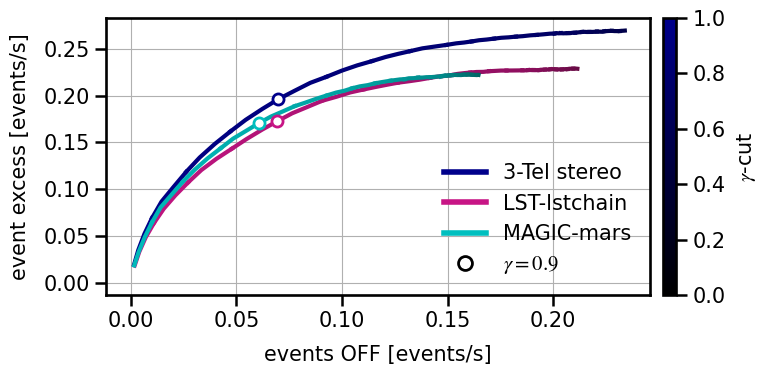

In [38]:
fig, ax = plt.subplots(figsize=(8,4))

zords = [1, 10, 1]

for i in range(len(n_offs_dyn_coinc)):
    
    cmap = aux.create_cmap(['k', cols[i]])
    
#     ax.plot(n_offs_dyn_coinc[i]/obs_time/n_regions_off, n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off, c=cols[i], lw=3, marker='', ls='-', zorder=1)
    
    sc = ax.scatter((n_offs_dyn_coinc[i]/obs_time/n_regions_off), (n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off),
               c=gamma_array_log, lw=3, marker='o', cmap=cmap, s=0, zorder=150)
    
    cma = sc.get_cmap()
    
    for j in range(len(n_offs_dyn_coinc[i])-4):
        if j%3 == 0:
            ax.plot((n_offs_dyn_coinc[i]/obs_time/n_regions_off)[j:j+4],
                    (n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off)[j:j+4],
                     c=cma(sc.norm(gamma_array_log[j])), lw=3, marker='', ls='-', zorder=zords[i])
    
    
gval = 0.9
for i in range(len(n_offs_dyn_coinc)):
    for g in range(len(gamma_array_log)-1):
        if gamma_array_log[g+1]>=gval and gamma_array_log[g]<gval:
            cmap = aux.create_cmap(['k', cols[i]])
            ax.plot((n_offs_dyn_coinc[i]/obs_time/n_regions_off)[g+1], (n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off)[g+1],
                       color=cols[i], marker='o', ms=8, lw=1, zorder=200, markerfacecolor='w')

    
for i in range(len(n_offs_dyn_coinc)):
    ax.plot([], [], c=cols[i], label=label_df[i], marker='', ls='-', ms=8) 
ax.plot([], [], c='k', label='$\gamma = 0.9$', marker='o', ls='', ms=10, markerfacecolor='w') 
    
cmap = aux.create_cmap(['k', cols[0]])
    
sc = ax.scatter(n_offs_dyn_coinc[i]/obs_time/n_regions_off, n_ons_dyn_coinc[i]/obs_time-n_offs_dyn_coinc[i]/obs_time/n_regions_off, c=gamma_array_log,
                s=0, lw=3, marker='o', cmap=cmap)

cbar = fig.colorbar(sc, ax=ax, cmap='plasma', pad=0.02)
cbar.set_label(label='$\gamma$-cut', labelpad=7)

ax.set_ylabel('event excess [events/s]', labelpad=10)
ax.set_xlabel('events OFF [events/s]', labelpad=10)

ax.legend(loc=4, frameon=False)
# fig.tight_layout()
# plt.yscale('log')
ax.grid(True, zorder=-10)
[line.set_zorder(10) for line in ax.lines]
fig.tight_layout()

# plt.savefig(f'{pltpath}on-excess-off-dist.pdf', bbox_inches='tight', dpi=dpi)


plt.show()

Stereo 3-T; Gamma cut $\gamma>0.7$, 185357 events


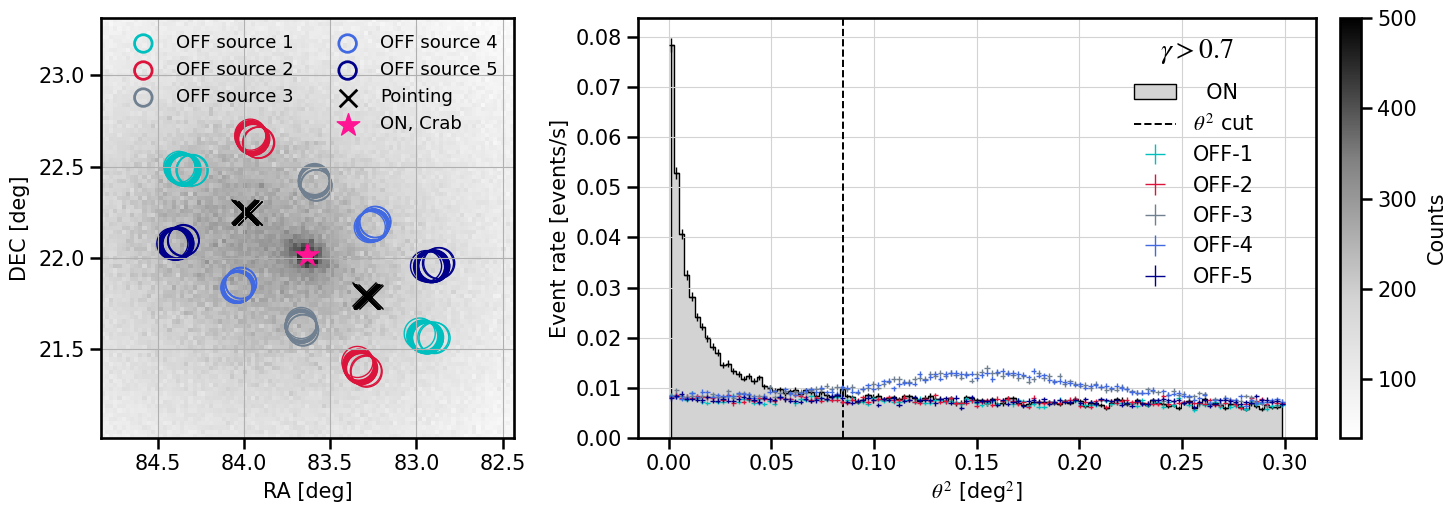

In [39]:
colors_off = ['c', 'crimson', 'slategray', 'royalblue', 'darkblue']

# extracting sky coordinates of the source we are studing
on_coord = SkyCoord.from_name(source_name, frame='icrs')

df = df_mean.copy()
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5.4), gridspec_kw={'width_ratios': [1, 2]})

obs_ids = np.unique(df.index.get_level_values('obs_id'))
for obs_id in obs_ids:

        df_events = df.query(f'obs_id == {obs_id}')

        # extracting event coordinates
        event_coords = SkyCoord(
            u.Quantity(df_events['reco_ra'], unit='deg'),
            u.Quantity(df_events['reco_dec'], unit='deg'),
            frame='icrs',)
        # extracting mean values
        pnt_ra_mean  = df_events['pointing_ra'].mean()  * u.deg
        pnt_dec_mean = df_events['pointing_dec'].mean() * u.deg

        # plot the pointing mean direction
        ax.scatter(pnt_ra_mean, pnt_dec_mean, marker='x', s=300, color='k', linewidths=1)

        # calculate the angular distances from the ON region
        theta2_on = on_coord.separation(event_coords).to_value('deg') ** 2

        # appending the data to the total dataframe
        df.loc[(obs_id, slice(None)), 'theta2_on'] = theta2_on

        # calculate the OFF coordinates
        off_coords = calculate_off_coordinates(
            pointing_ra=pnt_ra_mean,
            pointing_dec=pnt_dec_mean,
            on_coord_ra=on_coord.ra,
            on_coord_dec=on_coord.dec,
            n_regions=n_regions_off,)

        # iterate over all off regions
        off_iter = 0
        for i_off, off_coord in off_coords.items():
            # calculate the angular distance from the OFF coordinate
            theta2_off = off_coord.separation(event_coords).to_value('deg') ** 2

            # appending the data to the total dataframe
            df.loc[(obs_id, slice(None)), f'theta2_off{i_off}'] = theta2_off

            # plot the OFF coordinate
            ax.scatter(off_coord.ra.to('deg'), off_coord.dec.to('deg'), marker='o', s=500, facecolors='none', edgecolors=colors_off[off_iter])
            off_iter = off_iter + 1

# legend markers
for i in range(n_regions_off):
    if i == 3:
        ax.plot([], [], marker='', label=' ', ls='')
    ax.scatter([], [], marker='o', s=160, facecolors='none', edgecolors=colors_off[i], label=f'OFF source {i+1}', linewidths=2)

ax.scatter([], [], marker='x', s=160, color='k', linewidths=2, label='Pointing')
# plot the ON coordinate
ax.scatter(on_coord.ra.to('deg'), on_coord.dec.to('deg'), label=f'ON, {source_name}', marker='*', s=290, color='deeppink')

ax.set_xlabel('RA [deg]', labelpad=6)
ax.set_ylabel('DEC [deg]', labelpad=6)
# converting the coordinated to degrees and adding 2 degrees by both sides
xlim = on_coord.ra.to_value('deg')  + np.array([1.2, -1.2])
ylim = on_coord.dec.to_value('deg') + np.array([-1, 1.3])


Nbins = 100
cmap = colors.LinearSegmentedColormap.from_list('',  ['w','lightgray', 'gray', 'k'])
bins = [np.linspace(*np.flip(xlim), Nbins), np.linspace(*ylim, Nbins)]
hist, _ , _, im = ax.hist2d(df['reco_ra'], df['reco_dec'], bins=bins, cmap=cmap, zorder=-10)
cbar = fig.colorbar(im, ax=ax2, pad=0.03)
cbar.set_label(label='Counts', labelpad=7)


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.grid()
leg = ax.legend(loc=1, frameon=False, fontsize=13, ncol=2, numpoints=1) # bbox_to_anchor=(1.1, 1.05))
leg.get_frame().set_alpha(None)



theta2_cut  = 0.085
theta2_bins = np.linspace(0, 0.3, 120)
theta2_bins_c = (theta2_bins[:-1] + theta2_bins[1:]) / 2
theta2_bins_width = [theta2_bins_c - theta2_bins[:-1], theta2_bins[1:] - theta2_bins_c,]

gi = 1

print(f'Stereo 3-T; Gamma cut $\gamma>{gammas[gi]}$, {len(Ton_mean[gi])} events')

# hist_on, _, _ = ax2.hist(Ton_mean[gi], bins=theta2_bins, color='lightgrey', edgecolor='k', alpha=1, histtype='stepfilled', label='ON')

hist_on, _ = np.histogram(Ton_mean[gi], bins=theta2_bins)
ax2.fill_between(theta2_bins_c, hist_on/obs_time, color='lightgrey', edgecolor='k', step='mid', label='  ON')

ax2.errorbar(theta2_bins_c, hist_on/obs_time, xerr=theta2_bins_width, yerr=np.sqrt(hist_on)/obs_time, fmt='.', ms=0, color='k', zorder=10, lw=1)


for i in range(n_regions_off):
    hist_off, _ = np.histogram(Toff_mean[i][gi], bins=theta2_bins)
    ax2.errorbar(theta2_bins_c, hist_off/obs_time, xerr=theta2_bins_width, yerr=np.sqrt(hist_off)/obs_time, fmt='.', ms=0, color=colors_off[i], zorder=10, lw=1, label=f'OFF-{i+1}')

ax2.axvline(theta2_cut, color='k', lw=1.4, ls='--', label='$\\theta^2$ cut       ')
ax2.set_xlabel('$\\theta^2$ [deg$^2$]')
ax2.set_ylabel('Event rate [events/s]')
ax2.legend(loc=(0.72, 0.34), frameon=False)
ax2.grid(color='lightgray')
ax2.text(0.257, 0.077, f'$\gamma>{gammas[gi]}$', ha='center', va='center', fontsize=20)
ax2.set_ylim(0)

fig.tight_layout()


plt.savefig(f'{pltpath}ON-OFF-and-theta2.png', bbox_inches='tight', dpi=dpi)
plt.show()

# Sensitivity plots

In [40]:
##########################################################
compute_NonNoff = False
compute_sigma   = False
compute_sens    = False
Nbins = 150
gamma_array_sigmas  = np.linspace(0.001, 0.999,     Nbins)
theta2_array_sigmas = np.linspace(0.001, 0.13,  Nbins)
##########################################################


Gamma_mesh, Theta2_mesh = np.meshgrid(gamma_array_sigmas, theta2_array_sigmas)

if compute_NonNoff:
    
    Non_top_mean,  Noff_top_mean  = compute_Non_Noff(gamma_array_sigmas, theta2_array_sigmas, df_mean,  'top')
    Non_top_lst,   Noff_top_lst   = compute_Non_Noff(gamma_array_sigmas, theta2_array_sigmas, df_lst,   'top')
    Non_top_magic, Noff_top_magic = compute_Non_Noff(gamma_array_sigmas, theta2_array_sigmas, df_magic, 'top')
    
    Non_bottom_mean,  Noff_bottom_mean  = compute_Non_Noff(gamma_array_sigmas, theta2_array_sigmas, df_mean,  'bottom')
    Non_bottom_lst,   Noff_bottom_lst   = compute_Non_Noff(gamma_array_sigmas, theta2_array_sigmas, df_lst,   'bottom')
    Non_bottom_magic, Noff_bottom_magic = compute_Non_Noff(gamma_array_sigmas, theta2_array_sigmas, df_magic, 'bottom')    

    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_top_mean.txt',  Non_top_mean)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_top_mean.txt', Noff_top_mean)
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_bottom_mean.txt',  Non_bottom_mean)  
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_bottom_mean.txt', Noff_bottom_mean) 
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_top_lst.txt',  Non_top_lst)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_top_lst.txt', Noff_top_lst)
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_bottom_lst.txt',  Non_bottom_lst)   
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_bottom_lst.txt', Noff_bottom_lst)  
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_top_magic.txt',  Non_top_magic)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_top_magic.txt', Noff_top_magic)
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_bottom_magic.txt',  Non_bottom_magic)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_bottom_magic.txt', Noff_bottom_magic)

Non_top_mean,  Noff_top_mean  = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_top_mean.txt'),  np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_top_mean.txt')
Non_top_lst,   Noff_top_lst   = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_top_lst.txt'),   np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_top_lst.txt')
Non_top_magic, Noff_top_magic = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_top_magic.txt'), np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_top_magic.txt')

Non_bottom_mean,  Noff_bottom_mean  = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_bottom_mean.txt'),  np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_bottom_mean.txt')
Non_bottom_lst,   Noff_bottom_lst   = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_bottom_lst.txt'),   np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_bottom_lst.txt')
Non_bottom_magic, Noff_bottom_magic = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Non_bottom_magic.txt'), np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/Noff_bottom_magic.txt') 

if compute_sigma:
    
    sigma_top_mean  = compute_significance(Non_top_mean,  Noff_top_mean)
    sigma_top_lst   = compute_significance(Non_top_lst,   Noff_top_lst)
    sigma_top_magic = compute_significance(Non_top_magic, Noff_top_magic)
    
    sigma_bottom_mean  = compute_significance(Non_bottom_mean,  Noff_bottom_mean)
    sigma_bottom_lst   = compute_significance(Non_bottom_lst,   Noff_bottom_lst)
    sigma_bottom_magic = compute_significance(Non_bottom_magic, Noff_bottom_magic)
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_top_mean.txt',  sigma_top_mean)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_top_lst.txt',   sigma_top_lst)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_top_magic.txt', sigma_top_magic)
    
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_bottom_mean.txt',  sigma_bottom_mean)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_bottom_lst.txt',   sigma_bottom_lst)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_bottom_magic.txt', sigma_bottom_magic)

sigma_top_mean  = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_top_mean.txt')
sigma_top_lst   = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_top_lst.txt')
sigma_top_magic = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_top_magic.txt')

sigma_bottom_mean  = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_bottom_mean.txt')
sigma_bottom_lst   = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_bottom_lst.txt')
sigma_bottom_magic = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sigma_bottom_magic.txt')  

sigma_top    = [sigma_top_mean,    sigma_top_lst,    sigma_top_magic]
sigma_bottom = [sigma_bottom_mean, sigma_bottom_lst, sigma_bottom_magic]

if compute_sens:
    sens_top_mean  = compute_sensitivity(Non_top_mean,  Noff_top_mean)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_top_mean.txt', sens_top_mean)
    sens_top_lst   = compute_sensitivity(Non_top_lst,   Noff_top_lst)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_top_lst.txt', sens_top_lst)
    sens_top_magic = compute_sensitivity(Non_top_magic, Noff_top_magic)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_top_magic.txt', sens_top_magic)
    
    sens_bottom_mean  = compute_sensitivity(Non_bottom_mean,  Noff_bottom_mean)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_bottom_mean.txt', sens_bottom_mean)
    sens_bottom_lst   = compute_sensitivity(Non_bottom_lst,   Noff_bottom_lst)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_bottom_lst.txt', sens_bottom_lst)
    sens_bottom_magic = compute_sensitivity(Non_bottom_magic, Noff_bottom_magic)
    np.savetxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_bottom_magic.txt', sens_bottom_magic)
    
sens_top_mean  = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_top_mean.txt')
sens_top_lst   = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_top_lst.txt')
sens_top_magic = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_top_magic.txt')

sens_bottom_mean  = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_bottom_mean.txt')
sens_bottom_lst   = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_bottom_lst.txt')
sens_bottom_magic = np.loadtxt('/fefs/aswg/workspace/juan.jimenez/stereo_analysis/notebooks_analysis_dl2/data/sens_bottom_magic.txt')

sens_top    = [sens_top_mean,    sens_top_lst,    sens_top_magic]
sens_bottom = [sens_bottom_mean, sens_bottom_lst, sens_bottom_magic]

In [41]:
# extracting optimal values
max_indices_top_mean  = np.unravel_index(np.argmax(sigma_top_mean),  sigma_top_mean.shape)
max_indices_top_lst   = np.unravel_index(np.argmax(sigma_top_lst),   sigma_top_lst.shape)
max_indices_top_magic = np.unravel_index(np.argmax(sigma_top_magic), sigma_top_magic.shape)

max_indices_bottom_mean  = np.unravel_index(np.argmax(sigma_bottom_mean),  sigma_bottom_mean.shape)
max_indices_bottom_lst   = np.unravel_index(np.argmax(sigma_bottom_lst),   sigma_bottom_lst.shape)
max_indices_bottom_magic = np.unravel_index(np.argmax(sigma_bottom_magic), sigma_bottom_magic.shape)


# Retrieve the corresponding x and y values for each Z matrix
gamma_opt_top_mean  = Gamma_mesh[max_indices_top_mean]
gamma_opt_top_lst   = Gamma_mesh[max_indices_top_lst]
gamma_opt_top_magic = Gamma_mesh[max_indices_top_magic]

gamma_opt_bottom_mean  = Gamma_mesh[max_indices_bottom_mean]
gamma_opt_bottom_lst   = Gamma_mesh[max_indices_bottom_lst]
gamma_opt_bottom_magic = Gamma_mesh[max_indices_bottom_magic]

theta2_opt_top_mean  = Theta2_mesh[max_indices_top_mean]
theta2_opt_top_lst   = Theta2_mesh[max_indices_top_lst]
theta2_opt_top_magic = Theta2_mesh[max_indices_top_magic]

theta2_opt_bottom_mean  = Theta2_mesh[max_indices_bottom_mean]
theta2_opt_bottom_lst   = Theta2_mesh[max_indices_bottom_lst]
theta2_opt_bottom_magic = Theta2_mesh[max_indices_bottom_magic]

opt_top    = [[gamma_opt_top_mean, theta2_opt_top_mean], [gamma_opt_top_lst, theta2_opt_top_lst], [gamma_opt_top_magic, theta2_opt_top_magic]]
opt_bottom = [[gamma_opt_bottom_mean, theta2_opt_bottom_mean], [gamma_opt_bottom_lst, theta2_opt_bottom_lst], [gamma_opt_bottom_magic, theta2_opt_bottom_magic]]

opt_top = [[gamma_opt_top_mean, theta2_opt_top_mean], [gamma_opt_top_lst, theta2_opt_top_lst], [gamma_opt_top_magic, theta2_opt_top_magic]]

slice_opt_top    = [sigma_top_mean[:, max_indices_top_mean[0]], sigma_top_lst[:, max_indices_top_lst[0]], sigma_top_magic[:, max_indices_top_magic[0]]]
slice_opt_bottom = [sigma_bottom_mean[:, max_indices_bottom_mean[0]], sigma_bottom_lst[:, max_indices_bottom_lst[0]], sigma_bottom_magic[:, max_indices_bottom_magic[0]]]


In [42]:
# extracting optimal values
min_indices_top_mean  = np.unravel_index(np.argmin(sens_top_mean),  sens_top_mean.shape)
min_indices_top_lst   = np.unravel_index(np.argmin(sens_top_lst),   sens_top_lst.shape)
min_indices_top_magic = np.unravel_index(np.argmin(sens_top_magic), sens_top_magic.shape)

min_indices_bottom_mean  = np.unravel_index(np.argmin(sens_bottom_mean),  sens_bottom_mean.shape)
min_indices_bottom_lst   = np.unravel_index(np.argmin(sens_bottom_lst),   sens_bottom_lst.shape)
min_indices_bottom_magic = np.unravel_index(np.argmin(sens_bottom_magic), sens_bottom_magic.shape)


# Retrieve the corresponding x and y values for each Z matrix
gamma_opt_top_mean  = Gamma_mesh[min_indices_top_mean]
gamma_opt_top_lst   = Gamma_mesh[min_indices_top_lst]
gamma_opt_top_magic = Gamma_mesh[min_indices_top_magic]

gamma_opt_bottom_mean  = Gamma_mesh[min_indices_bottom_mean]
gamma_opt_bottom_lst   = Gamma_mesh[min_indices_bottom_lst]
gamma_opt_bottom_magic = Gamma_mesh[min_indices_bottom_magic]

theta2_opt_top_mean  = Theta2_mesh[min_indices_top_mean]
theta2_opt_top_lst   = Theta2_mesh[min_indices_top_lst]
theta2_opt_top_magic = Theta2_mesh[min_indices_top_magic]

theta2_opt_bottom_mean  = Theta2_mesh[min_indices_bottom_mean]
theta2_opt_bottom_lst   = Theta2_mesh[min_indices_bottom_lst]
theta2_opt_bottom_magic = Theta2_mesh[min_indices_bottom_magic]

opt_top    = [[gamma_opt_top_mean, theta2_opt_top_mean], [gamma_opt_top_lst, theta2_opt_top_lst], [gamma_opt_top_magic, theta2_opt_top_magic]]
opt_bottom = [[gamma_opt_bottom_mean, theta2_opt_bottom_mean], [gamma_opt_bottom_lst, theta2_opt_bottom_lst], [gamma_opt_bottom_magic, theta2_opt_bottom_magic]]

opt_top = [[gamma_opt_top_mean, theta2_opt_top_mean], [gamma_opt_top_lst, theta2_opt_top_lst], [gamma_opt_top_magic, theta2_opt_top_magic]]

slice_opt_top    = [sens_top_mean[:, min_indices_top_mean[0]], sens_top_lst[:, min_indices_top_lst[0]], sens_top_magic[:, min_indices_top_magic[0]]]
slice_opt_bottom = [sens_bottom_mean[:, min_indices_bottom_mean[0]], sens_bottom_lst[:, min_indices_bottom_lst[0]], sens_bottom_magic[:, min_indices_bottom_magic[0]]]


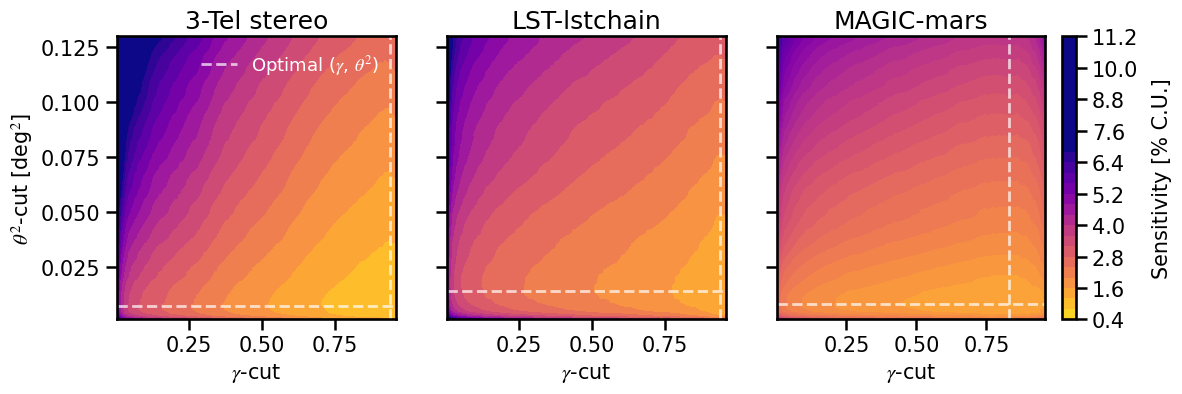

In [43]:
cmap = 'plasma_r'
levels = 30
vmax = 7
vmin = 0
NN = 6

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.2), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.2]})
axes = [ax1, ax2, ax3] 

sigmas = sens_top

for m in range(len(sigmas)):
    if m == 0:
        cf = axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    else:
        axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    axes[m].axvline(opt_top[m][0], color='w', lw=2, alpha=0.7, ls='--')
    axes[m].axhline(opt_top[m][1], color='w', lw=2, alpha=0.7, ls='--')
    
    axes[m].set_title(label_df[m])
    
cb = fig.colorbar(cf, ax=ax3)
cb.set_label('Sensitivity [% C.U.]', labelpad=10)

ax1.plot([],[], color='w', lw=2, alpha=0.7, ls='--', label='Optimal ($\gamma$, $\\theta^2$)')
ax1.legend(frameon=False, fontsize=13, labelcolor='w')

for ax, t in zip(axes, label_df):
    ax.set_xlabel('$\gamma$-cut')
ax1.set_ylabel('$\\theta^2$-cut [deg${}^2$]')

fig.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0)

# plt.savefig(f'{pltpath}sensitivity-top-gamma-theta.png', bbox_inches='tight', dpi=dpi)

plt.show()

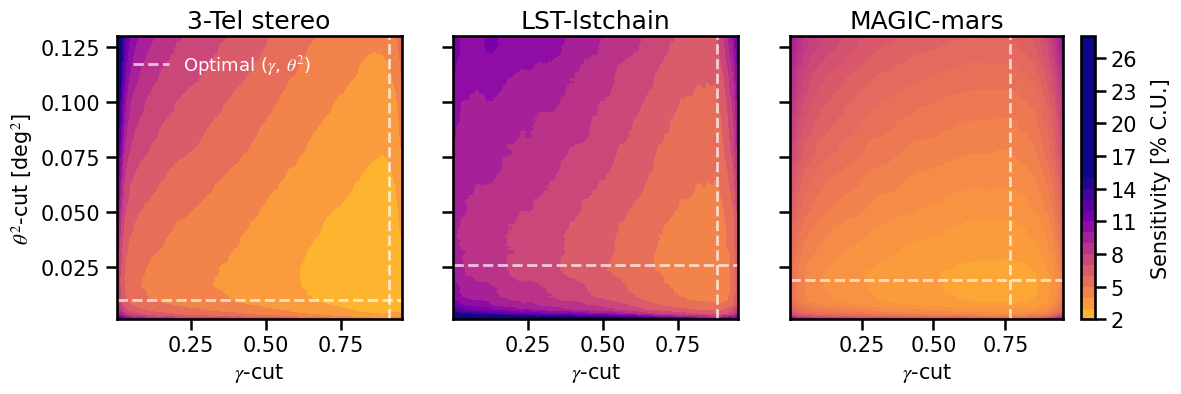

In [44]:
cmap = 'plasma_r'
levels = 30
vmax = 15
vmin = 0
NN = 7

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.2), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1.2]})
axes = [ax1, ax2, ax3] 

sigmas = sens_bottom


for m in range(len(sigmas)):
    if m == 0:
        cf = axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    else:
        axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
        
    if m == 2:
        axes[m].axvline(opt_bottom[m][0], color='w', lw=2, alpha=0.7, ls='--')
        axes[m].axhline(opt_bottom[m][1], color='w', lw=2, alpha=0.7, ls='--')
    elif m == 0:
        axes[m].axvline(0.91, color='w', lw=2, alpha=0.7, ls='--')
        axes[m].axhline(0.01, color='w', lw=2, alpha=0.7, ls='--')   
    elif m == 1:
        axes[m].axvline(0.88, color='w', lw=2, alpha=0.7, ls='--')
        axes[m].axhline(0.0256, color='w', lw=2, alpha=0.7, ls='--')   
    
    axes[m].set_title(label_df[m])
    
cb = fig.colorbar(cf, ax=ax3)
cb.set_label('Sensitivity [% C.U.]', labelpad=10)

ax1.plot([],[], color='w', lw=2, alpha=0.7, ls='--', label='Optimal ($\gamma$, $\\theta^2$)')
ax1.legend(frameon=False, fontsize=13, labelcolor='w')

for ax, t in zip(axes, label_df):
    ax.set_xlabel('$\gamma$-cut')
ax1.set_ylabel('$\\theta^2$-cut [deg${}^2$]')

fig.tight_layout()
plt.subplots_adjust(wspace=0.17, hspace=0)

# plt.savefig(f'{pltpath}sensitivity-top-gamma-theta.png', bbox_inches='tight', dpi=dpi)

plt.show()

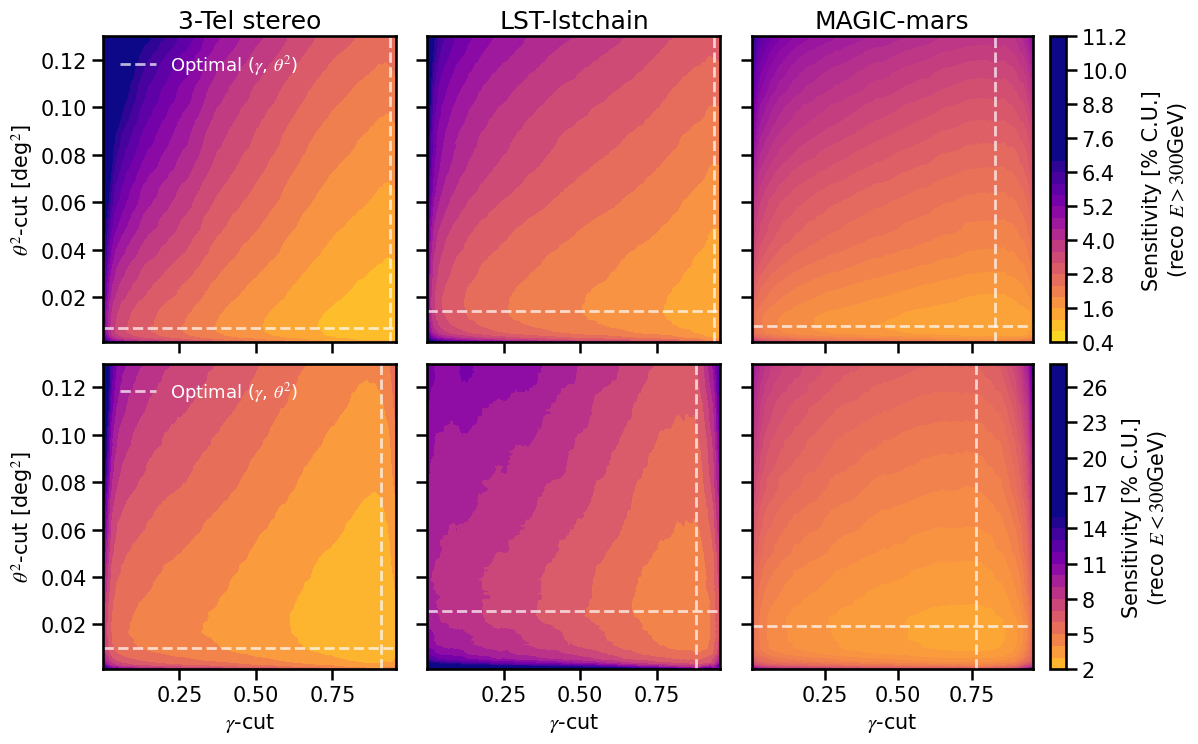

In [45]:
cmap = 'plasma_r'
levels = 30
vmax = 7
vmin = 0
NN = 6

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12.4, 7.7), sharey=True, sharex='col', gridspec_kw={'width_ratios': [1, 1, 1.2]})
axes = [ax1, ax2, ax3] 

sigmas = sens_top

for m in range(len(sigmas)):
    if m == 0:
        cf = axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    else:
        axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    axes[m].axvline(opt_top[m][0], color='w', lw=2, alpha=0.7, ls='--')
    axes[m].axhline(opt_top[m][1], color='w', lw=2, alpha=0.7, ls='--')
    
    axes[m].set_title(label_df[m])
    
cb = fig.colorbar(cf, ax=ax3)
cb.set_label('Sensitivity [% C.U.]\n(reco $E>300$GeV)', labelpad=10)

ax1.plot([],[], color='w', lw=2, alpha=0.7, ls='--', label='Optimal ($\gamma$, $\\theta^2$)')
ax4.plot([],[], color='w', lw=2, alpha=0.7, ls='--', label='Optimal ($\gamma$, $\\theta^2$)')
ax1.legend(frameon=False, fontsize=13, labelcolor='w', loc=2)
ax4.legend(frameon=False, fontsize=13, labelcolor='w', loc=2)


cmap = 'plasma_r'
levels = 30
vmax = 15
vmin = 0
NN = 6

axes = [ax4, ax5, ax6] 

sigmas = sens_bottom


for m in range(len(sigmas)):
    if m == 0:
        cf = axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
    else:
        axes[m].contourf(gamma_array_sigmas[:-NN], theta2_array_sigmas, sigmas[m][:, :-NN], vmax=vmax, vmin=vmin, levels=levels, cmap=cmap)
        
    if m == 2:
        axes[m].axvline(opt_bottom[m][0], color='w', lw=2, alpha=0.7, ls='--')
        axes[m].axhline(opt_bottom[m][1], color='w', lw=2, alpha=0.7, ls='--')
    elif m == 0:
        axes[m].axvline(0.91, color='w', lw=2, alpha=0.7, ls='--')
        axes[m].axhline(0.01, color='w', lw=2, alpha=0.7, ls='--')   
    elif m == 1:
        axes[m].axvline(0.88, color='w', lw=2, alpha=0.7, ls='--')
        axes[m].axhline(0.0256, color='w', lw=2, alpha=0.7, ls='--')   

cb = fig.colorbar(cf, ax=ax6)
cb.set_label('Sensitivity [% C.U.]\n(reco $E<300$GeV)', labelpad=10)


for ax, t in zip(axes, label_df):
    ax.set_xlabel('$\gamma$-cut')
ax1.set_ylabel('$\\theta^2$-cut [deg${}^2$]')
ax4.set_ylabel('$\\theta^2$-cut [deg${}^2$]')


fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.07)

plt.savefig(f'{pltpath}sensitivity-gamma-theta.png', bbox_inches='tight', dpi=dpi)

plt.show()

In [46]:
opt_top

[[0.9387181208053691, 0.0070604026845637585],
 [0.9387181208053691, 0.013986577181208056],
 [0.8315503355704698, 0.007926174496644296]]

In [47]:
np.min(sens_top[0]), np.min(sens_top[1]), np.min(sens_top[2])

(0.7916921753800205, 1.2131530681830398, 1.3828475916453715)

In [48]:
opt_bottom

[[0.999, 0.001],
 [0.9923020134228188, 0.001],
 [0.7645704697986577, 0.019181208053691275]]

In [49]:
np.nanmin(sens_bottom[0]), np.nanmin(sens_bottom[1]), np.min(sens_bottom[2])

(2.0937104908126822, 4.206742079275379, 2.989250813661464)